In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Circle
import numpy as np 
import pickle

전체 데이터 EDA


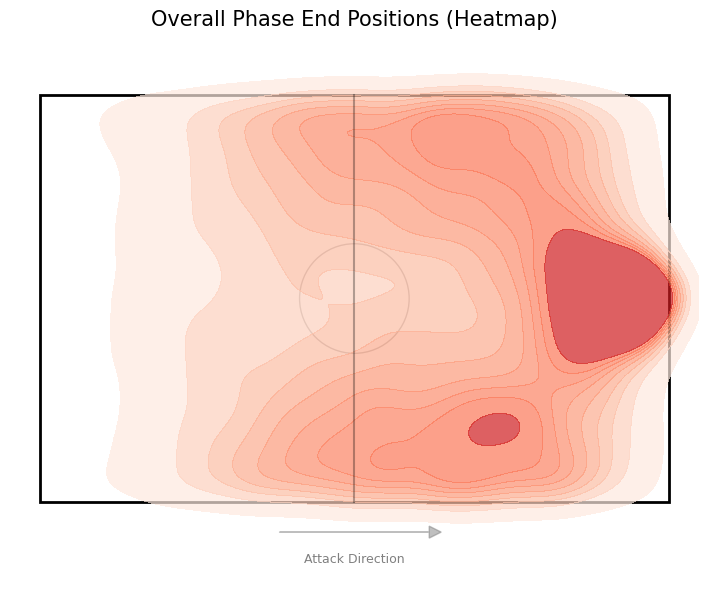

In [3]:
# 1. 데이터 로드
df = pd.read_csv('./open_track1/train.csv')
df = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds', 'action_id'])

df['unique_ep_id'] = df['game_id'].astype(str) + '_' + df['period_id'].astype(str) + '_' + df['episode_id'].astype(str)

# Phase 변경 감지: (에피소드가 바뀌거나) OR (팀이 바뀌거나)
is_new_episode = df['unique_ep_id'] != df['unique_ep_id'].shift()
is_team_change = df['team_id'] != df['team_id'].shift()
# 누적 합(cumsum)을 통해 고유한 phase_id 생성
df['phase_id'] = (is_new_episode | is_team_change).cumsum()

# 3. Phase별 데이터 요약 (Start Action, End Position)
phase_summary = df.groupby('phase_id').agg(
    start_action=('type_name', 'first'),  # Phase의 시작 행동
    end_x=('end_x', 'last'),              # Phase의 끝 위치 X
    end_y=('end_y', 'last'),              # Phase의 끝 위치 Y
    count=('action_id', 'count')          # Phase 길이 (이벤트 개수)
).reset_index()

# 4. 시각화

# 경기장 그리기 헬퍼 함수
def draw_pitch(ax):
    # 외곽선 및 중앙선
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    
    # 공격 방향 표시 (왼쪽 -> 오른쪽)
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

# (1) 전체 Phase 종료 위치 Heatmap
plt.figure(figsize=(10, 7))
ax = plt.gca()
draw_pitch(ax)
sns.kdeplot(
    x=phase_summary['end_x'],
    y=phase_summary['end_y'],
    fill=True,
    cmap='Reds',
    thresh=0.05,
    alpha=0.7,
    ax=ax
)
plt.title("Overall Phase End Positions (Heatmap)", fontsize=15, pad=20)
plt.show()

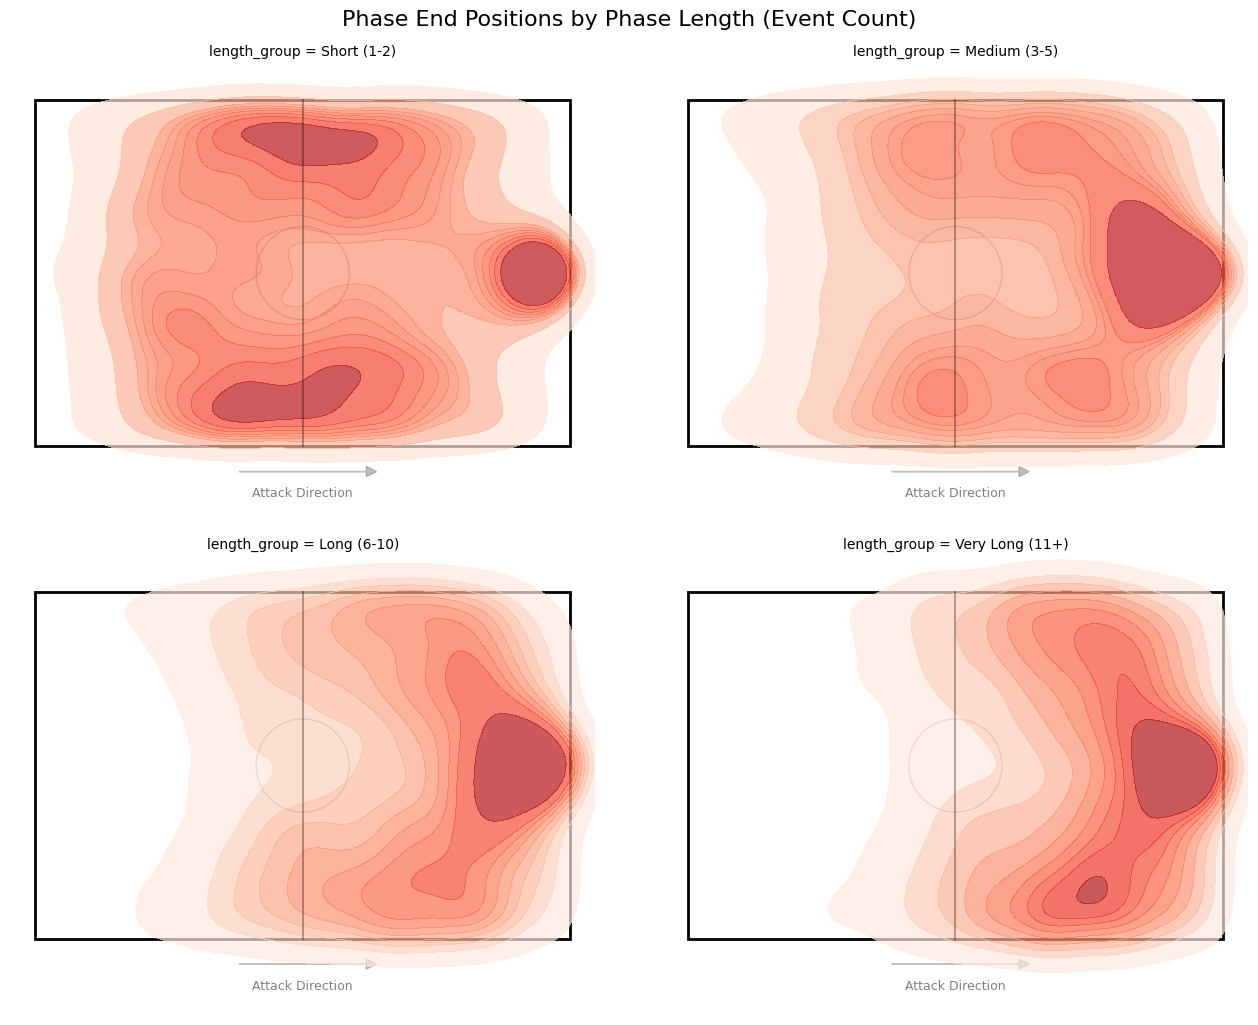

=== Phase Length Group Counts ===
length_group
Short (1-2)        25410
Medium (3-5)       20553
Long (6-10)        11852
Very Long (11+)     8916
Name: count, dtype: int64


In [17]:
phase_summary = df.groupby('phase_id').agg(
    phase_length=('action_id', 'count'),  # Phase 길이 (이벤트 수)
    end_x=('end_x', 'last'),              # 종료 위치 X
    end_y=('end_y', 'last'),              # 종료 위치 Y
    is_home=('is_home', 'first')          # 팀 정보
).reset_index()

# 3. Phase 길이 구간화 (Binning)
# 분포를 고려하여 4개 구간으로 나눔
bins = [0, 2, 5, 10, np.inf]
labels = ['Short (1-2)', 'Medium (3-5)', 'Long (6-10)', 'Very Long (11+)']
phase_summary['length_group'] = pd.cut(phase_summary['phase_length'], bins=bins, labels=labels)

# 4. 시각화

# 경기장 그리기 함수
def draw_pitch(ax):
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_kde_on_pitch(x, y, **kwargs):
    ax = plt.gca()
    draw_pitch(ax)
    sns.kdeplot(x=x, y=y, fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=ax)

# (1) Phase 길이별 종료 위치 시각화
g1 = sns.FacetGrid(phase_summary, col="length_group", col_wrap=2, height=5, aspect=1.4)
g1.map(plot_kde_on_pitch, "end_x", "end_y")
g1.fig.suptitle("Phase End Positions by Phase Length (Event Count)", fontsize=16, y=1.02)
plt.show()

print("=== Phase Length Group Counts ===")
print(phase_summary['length_group'].value_counts())

각 팀별 데이터 EDA (Phase)

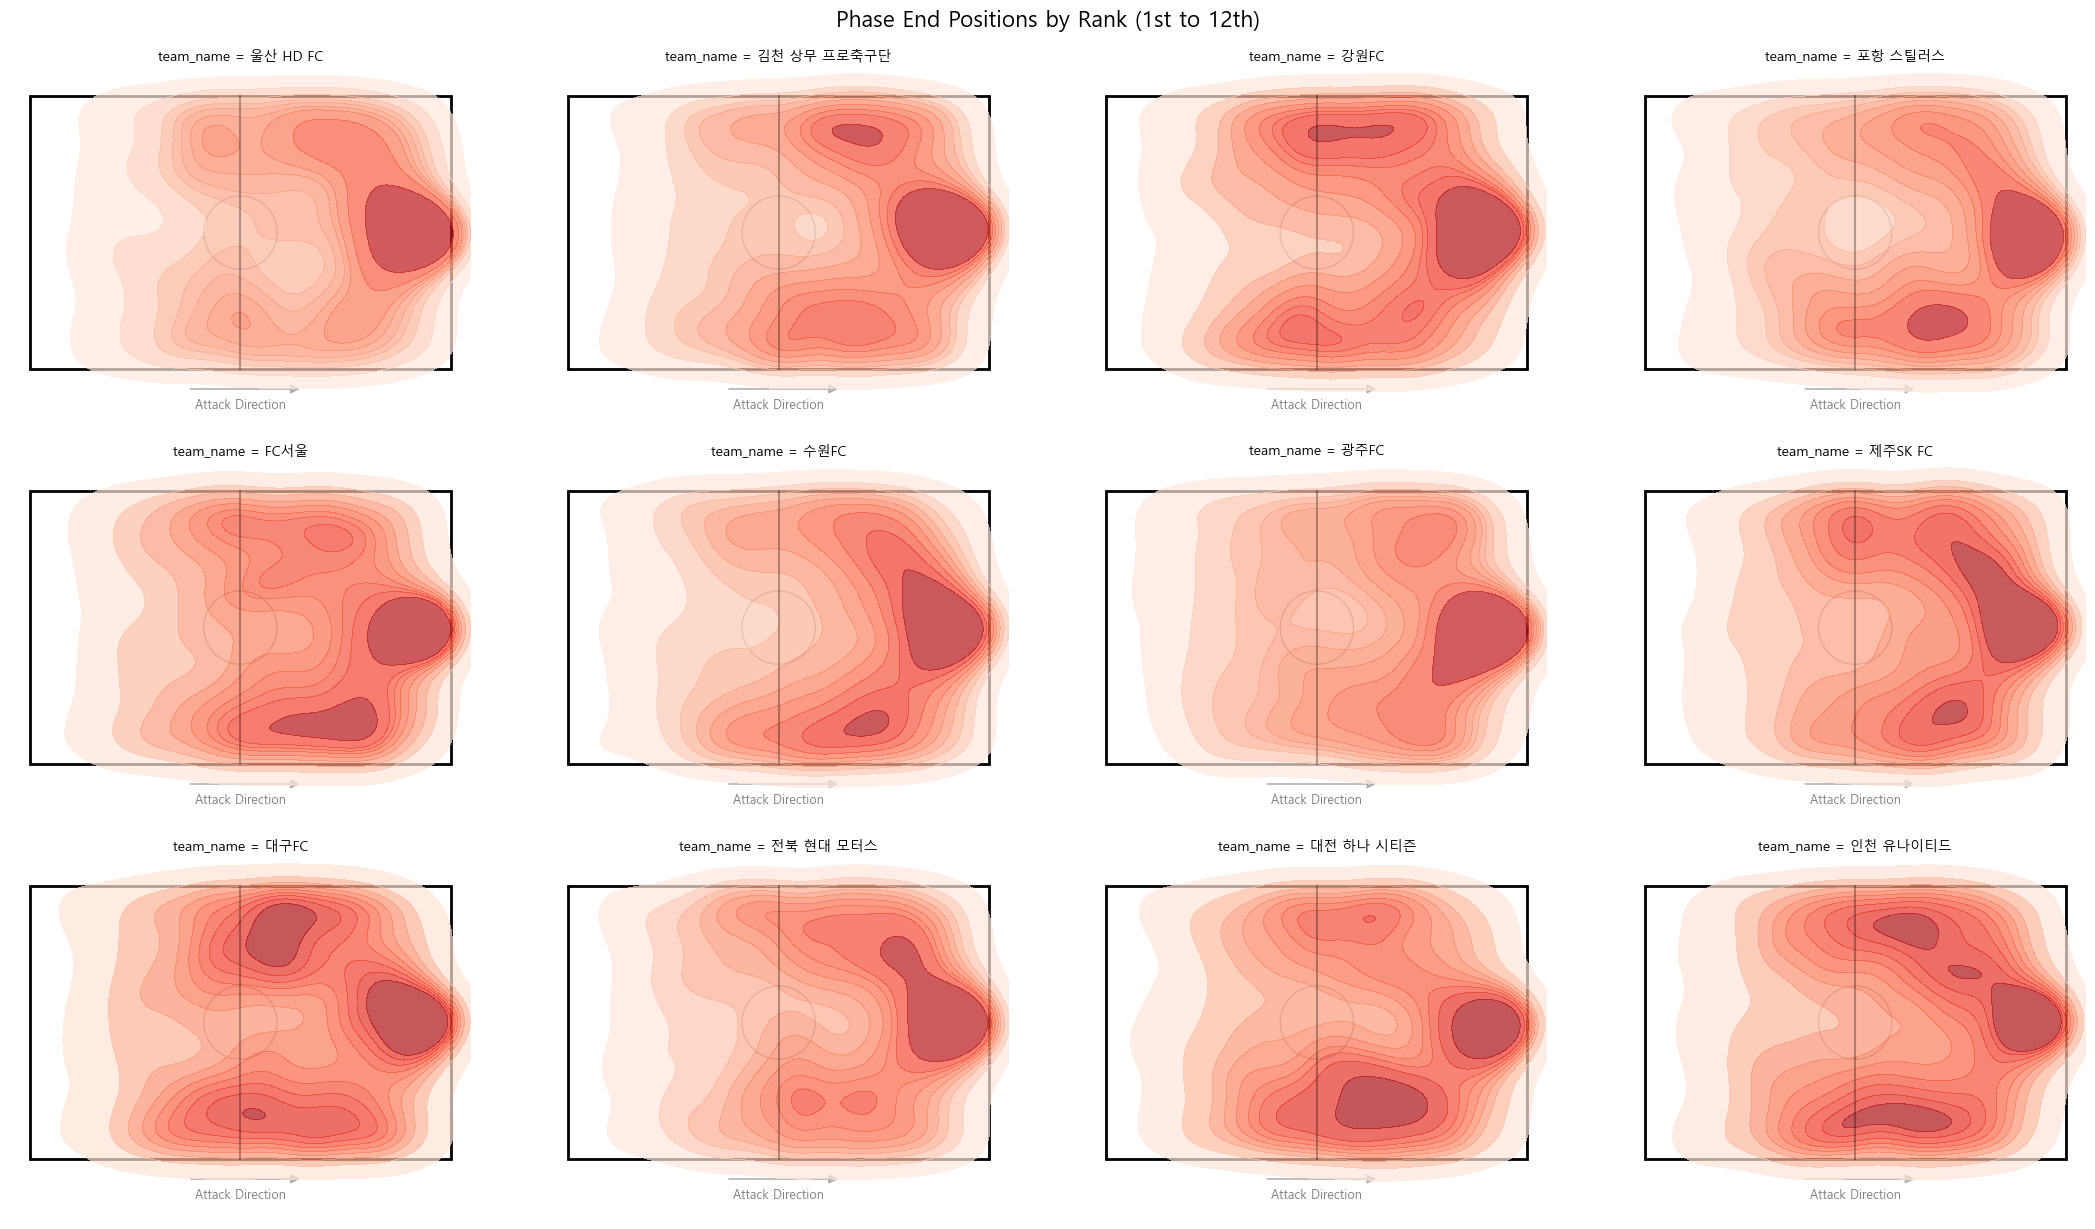

In [15]:
# 한글 폰트 설정 (환경에 맞게 변경)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드 및 전처리
with open('match_data.pkl', 'rb') as f:
    match_data = pickle.load(f)

id_to_name = {k: v['name'] for k, v in match_data['team_dict'].items()}

# (df가 이미 로드되어 있다고 가정)
# df = pd.read_csv(...) 

df = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds'])
df['unique_ep_id'] = df['game_id'].astype(str) + '_' + df['period_id'].astype(str) + '_' + df['episode_id'].astype(str)
is_new_episode = df['unique_ep_id'] != df['unique_ep_id'].shift()
is_team_change = df['team_id'] != df['team_id'].shift()
df['phase_id'] = (is_new_episode | is_team_change).cumsum()

# 2. Phase별 요약 및 팀 이름 매핑
phase_summary = df.groupby('phase_id').agg(
    end_x=('end_x', 'last'),
    end_y=('end_y', 'last'),
    team_id=('team_id', 'first'),
    count=('action_id', 'count')
).reset_index()

phase_summary['team_name'] = phase_summary['team_id'].map(id_to_name)

# -----------------------------------------------------------
# [핵심] 이미지의 순위대로 팀 정렬 리스트 정의
# 주의: pkl 파일 내부의 '정확한 팀 이름'과 일치해야 합니다.
# -----------------------------------------------------------
ordered_teams = [
    "울산 HD FC",           # 1위
    "김천 상무 프로축구단",   # 2위
    "강원FC",              # 3위
    "포항 스틸러스",          # 4위
    "FC서울",               # 5위
    "수원FC",              # 6위
    "광주FC",               # 7위
    "제주SK FC",        # 8위 (만약 에러나면 '제주SK FC' 등으로 이름 확인 필요)
    "대구FC",               # 9위
    "전북 현대 모터스",       # 10위
    "대전 하나 시티즌",       # 11위
    "인천 유나이티드"         # 12위
]

# 데이터에 있는 팀만 필터링 (혹시 이름이 조금 달라도 에러 안 나게 처리)
valid_teams = [t for t in ordered_teams if t in phase_summary['team_name'].unique()]
filtered_data = phase_summary[phase_summary['team_name'].isin(valid_teams)].copy()

# 'team_name' 컬럼을 Categorical 타입으로 변환하여 순서 강제 적용
filtered_data['team_name'] = pd.Categorical(
    filtered_data['team_name'],
    categories=valid_teams,
    ordered=True
)

# 3. 시각화 함수 정의
def draw_pitch(ax):
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_kde_on_pitch(x, y, **kwargs):
    ax = plt.gca()
    draw_pitch(ax)
    sns.kdeplot(x=x, y=y, fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=ax)

# 4. 시각화 실행 (순서가 적용된 상태)
g = sns.FacetGrid(filtered_data, col="team_name", col_wrap=4, height=4, aspect=1.4)
g.map(plot_kde_on_pitch, "end_x", "end_y")

g.fig.suptitle("Phase End Positions by Rank (1st to 12th)", fontsize=16, y=1.02)
plt.show()

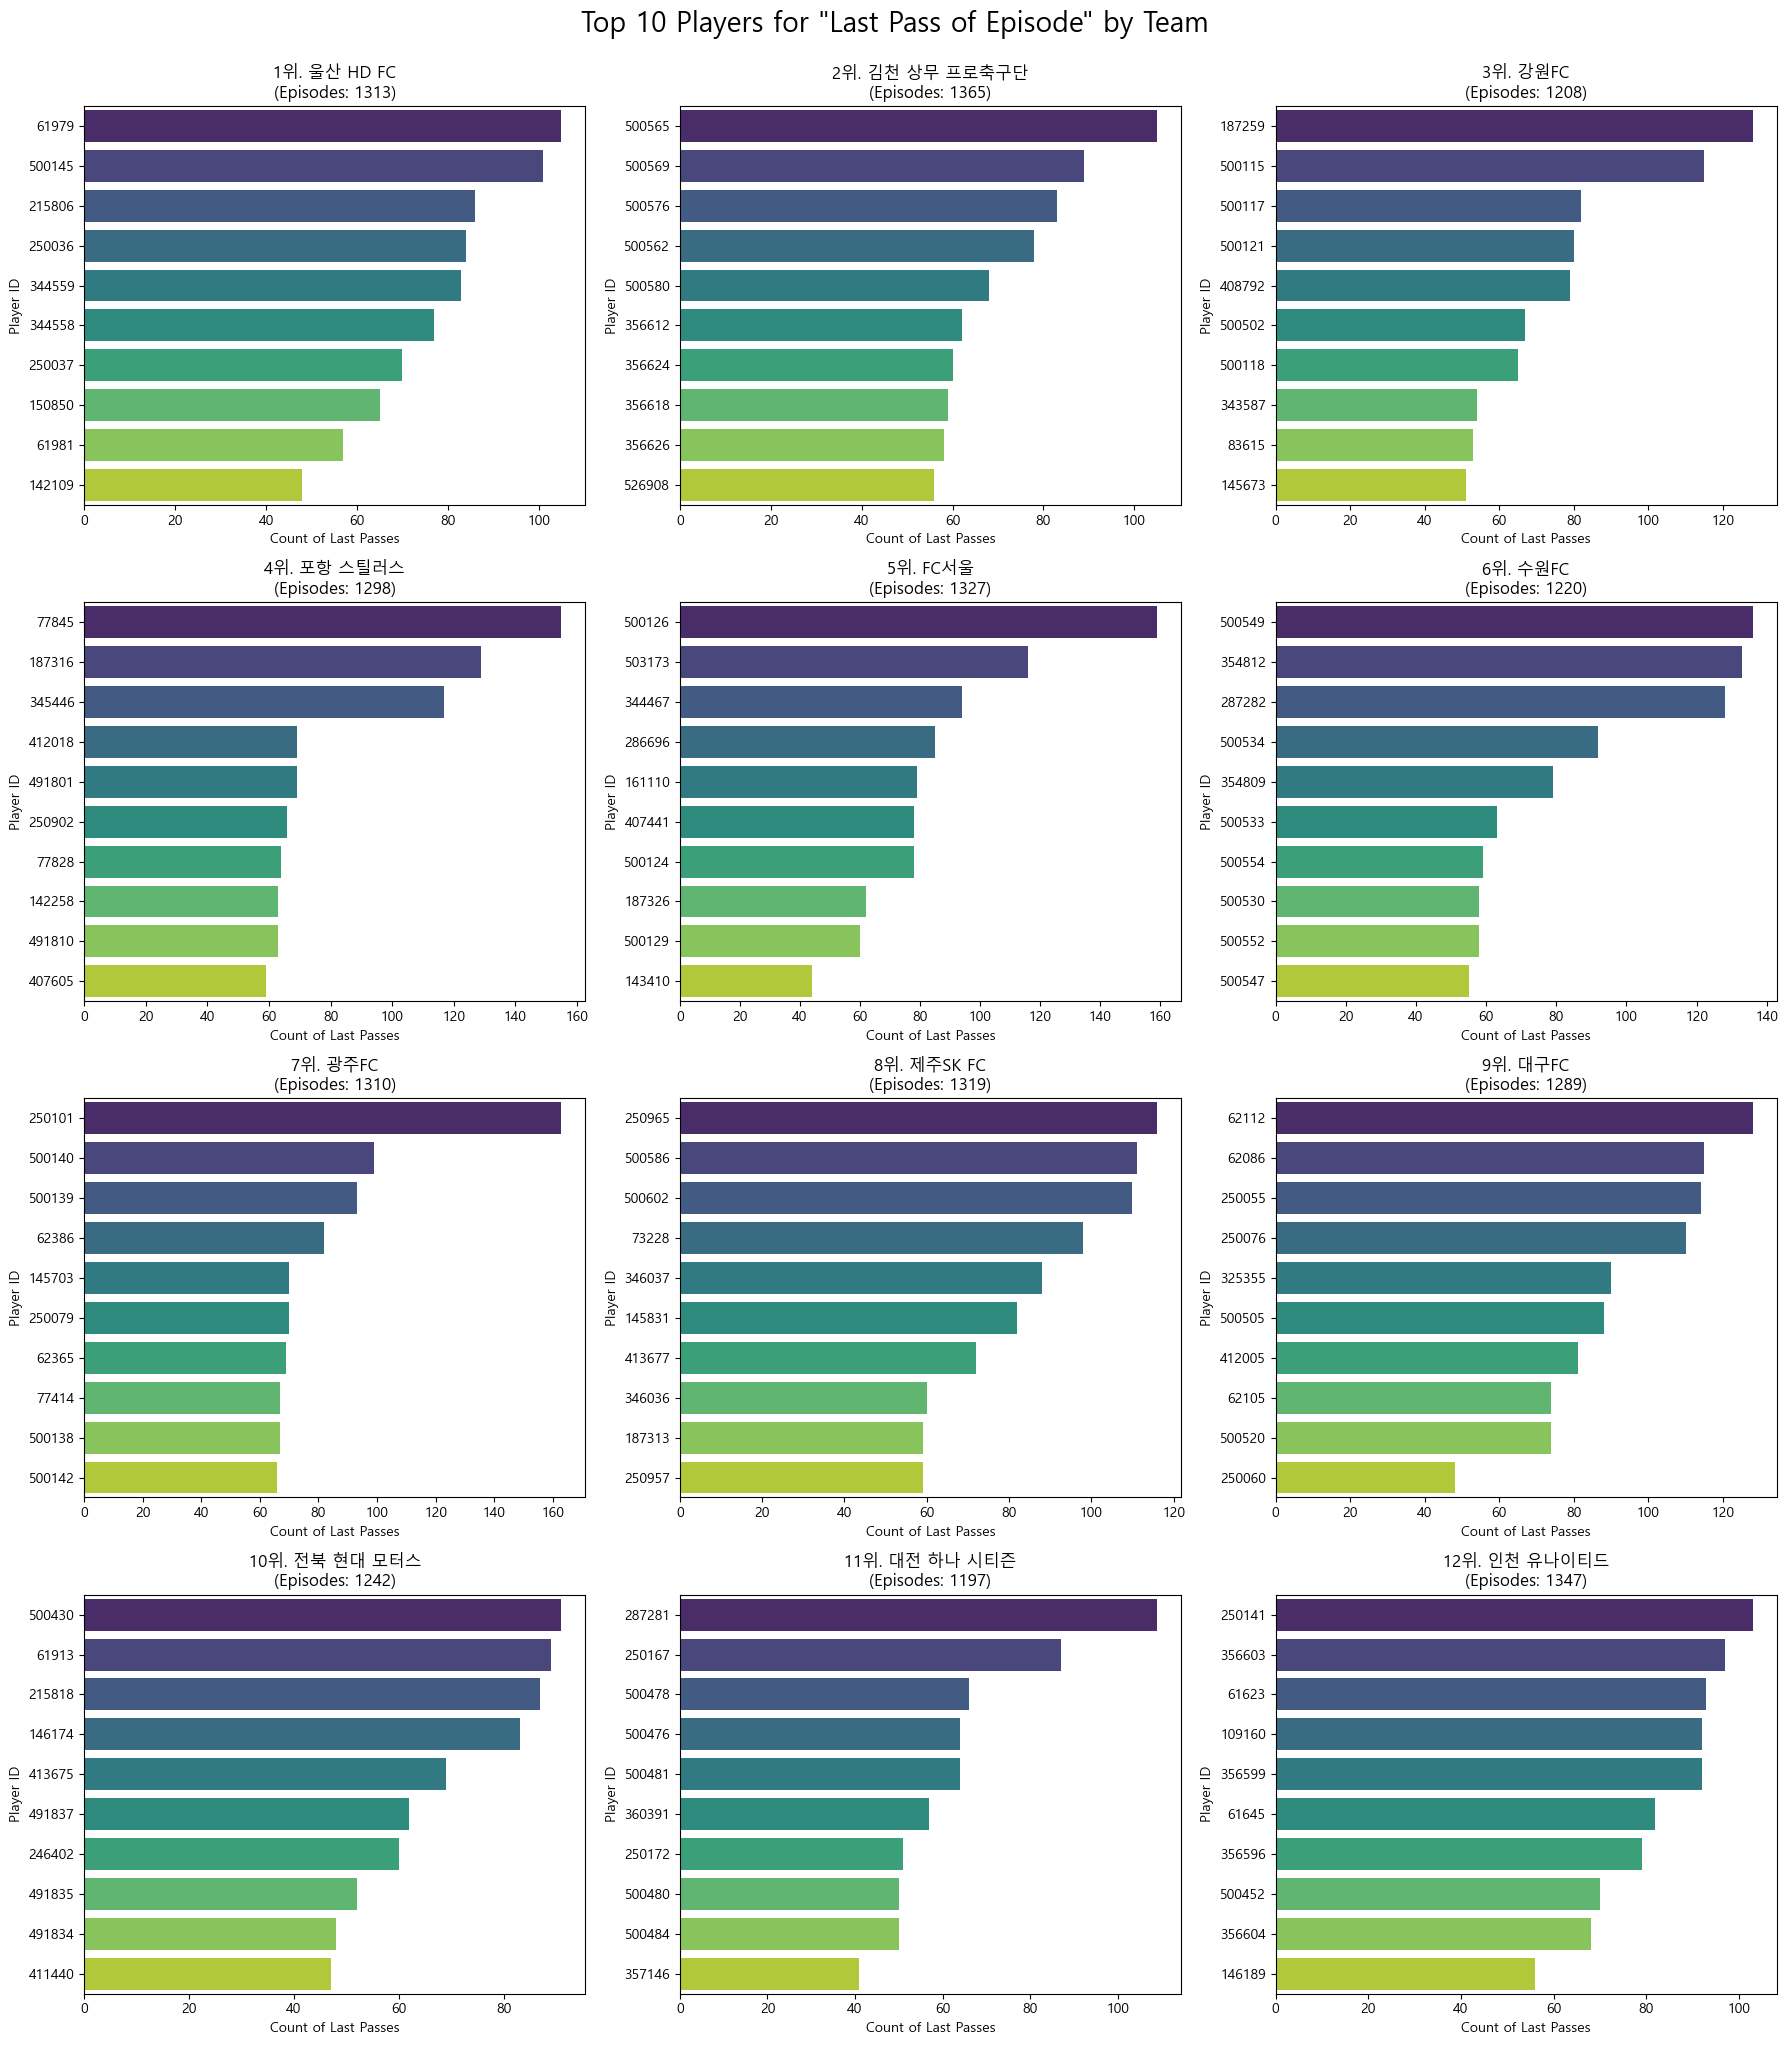

Total Episodes: 15435
team_name
김천 상무 프로축구단    1365
인천 유나이티드       1347
FC서울           1327
제주SK FC        1319
울산 HD FC       1313
광주FC           1310
포항 스틸러스        1298
대구FC           1289
전북 현대 모터스      1242
수원FC           1220
강원FC           1208
대전 하나 시티즌      1197
Name: count, dtype: int64


In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

with open('match_data.pkl', 'rb') as f:
    match_data = pickle.load(f)
id_to_name = {k: v['name'] for k, v in match_data['team_dict'].items()}

df['team_name'] = df['team_id'].map(id_to_name)

# 2. '패스'로 간주할 액션 타입 정의
pass_types = ['Pass', 'Pass_Freekick', 'Pass_Corner', 'Cross']

# 패스 이벤트만 필터링
pass_df = df[df['type_name'].isin(pass_types)].copy()

# 2. 에피소드 수 계산 (전체 및 팀별)
# 에피소드 ID별로 그룹화하여 하나로 합침 (마지막 액션 기준 팀 할당)
episode_last_actions = df.groupby(['game_id', 'period_id', 'episode_id']).last().reset_index()

# 전체 에피소드 개수
total_episodes = len(episode_last_actions)

# 팀별 에피소드 개수
team_episode_counts = episode_last_actions['team_name'].value_counts()

# 3. 에피소드별 마지막 패스 추출
# 시간순 정렬
pass_df = pass_df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds'])

# 그룹화하여 마지막 이벤트 선택 (에피소드당 1개의 마지막 패스)
last_passes = pass_df.groupby(['game_id', 'period_id', 'episode_id']).last().reset_index()

# 4. 선수별 통계 집계
player_stats = last_passes.groupby(['team_name', 'player_id']).size().reset_index(name='count')
player_stats = player_stats.sort_values(['team_name', 'count'], ascending=[True, False])

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

for i, team_name in enumerate(ordered_teams):
    ax = axes[i]
    
    # 해당 팀 데이터 및 에피소드 수 가져오기
    team_stats = player_stats[player_stats['team_name'] == team_name]
    ep_count = team_episode_counts.get(team_name, 0)
    
    if team_stats.empty:
        ax.text(0.5, 0.5, 'No Data', ha='center')
        ax.set_title(f"{i+1}위. {team_name}\n(Total Episodes: {ep_count})")
        continue
    
    top_players = team_stats.head(10)
    
    # 그래프 그리기 (hue 추가, legend 제거)
    sns.barplot(
        x='count', 
        y=top_players['player_id'].astype(str), 
        hue=top_players['player_id'].astype(str),
        data=top_players, 
        ax=ax, 
        orient='h', 
        palette='viridis',
        order=top_players['player_id'].astype(str),
        dodge=False
    )
    
    # 범례 제거
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    # 제목에 에피소드 수 정보 추가
    ax.set_title(f"{i+1}위. {team_name}\n(Episodes: {ep_count})")
    ax.set_xlabel('Count of Last Passes')
    ax.set_ylabel('Player ID')

plt.tight_layout()
# 전체 제목에 총 에피소드 수 추가
plt.suptitle(f'Top 10 Players for "Last Pass of Episode" by Team', fontsize=20, y=1.02)
plt.show()

# (참고용) 팀별 에피소드 수 출력
print(f"Total Episodes: {total_episodes}")
print(team_episode_counts)

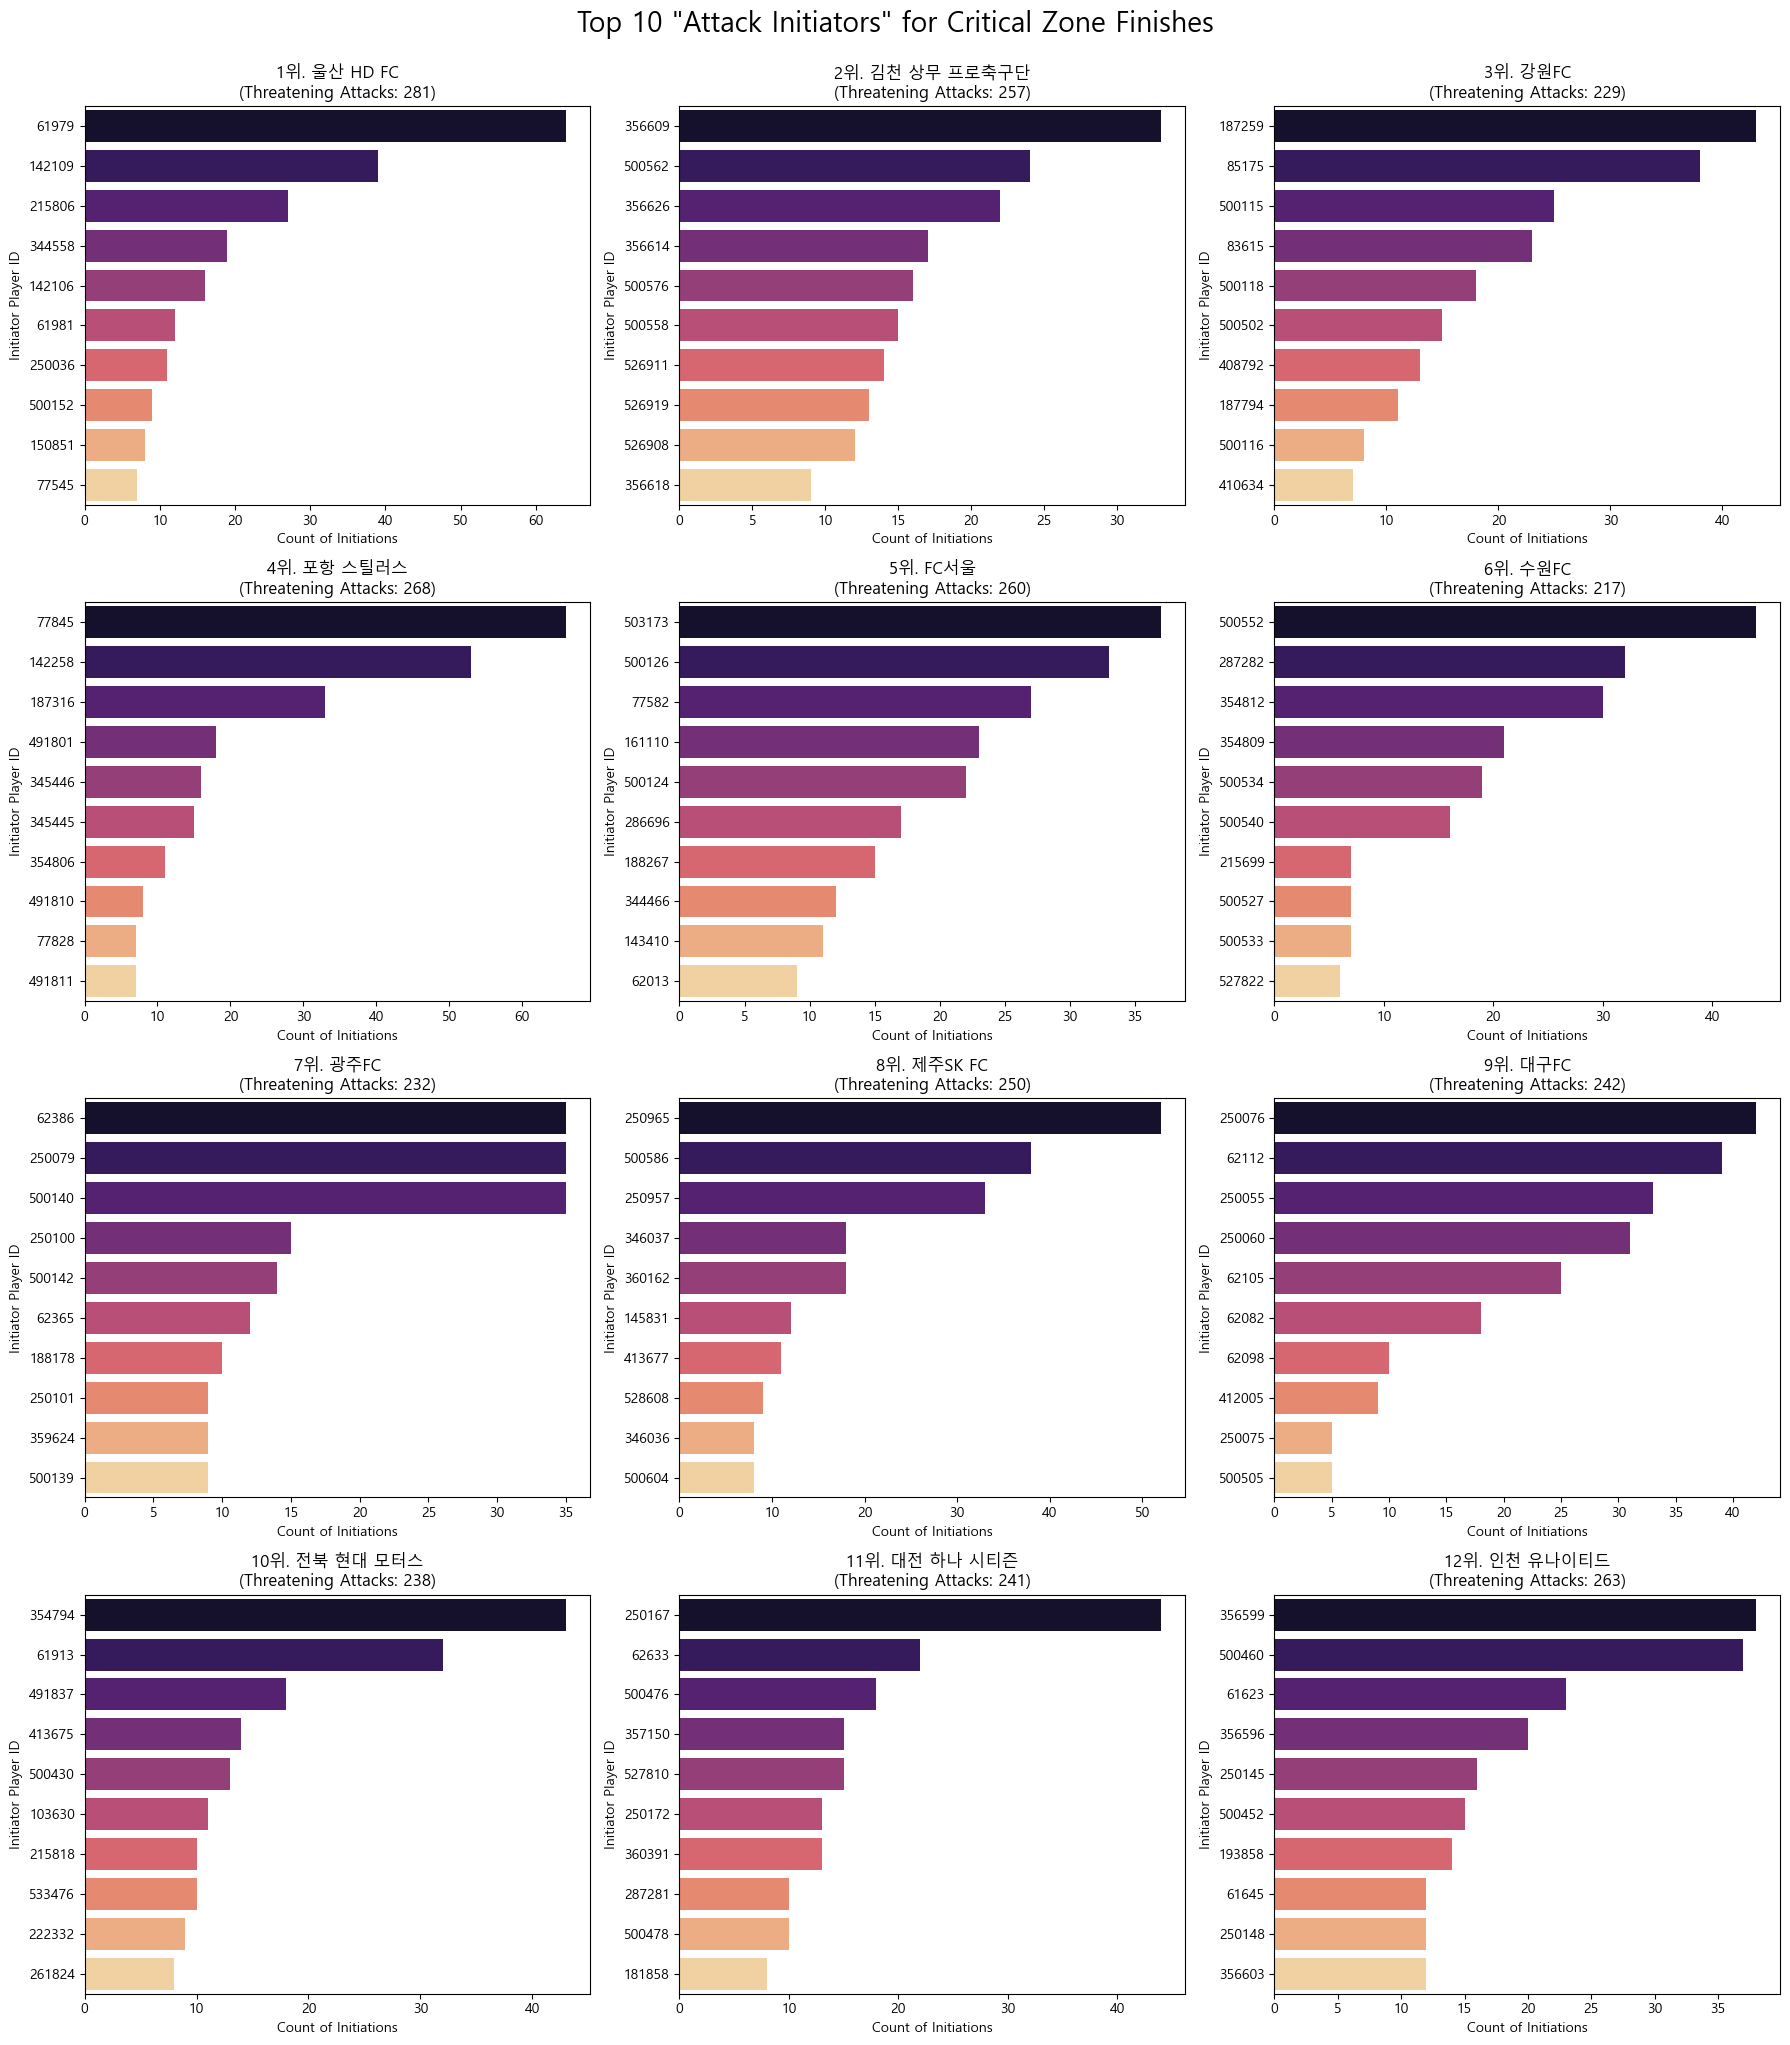

Total Threatening Attacks Analyzed: 2978


In [26]:
CRITICAL_X_MIN = 80.0
CRITICAL_Y_MIN = 13.84
CRITICAL_Y_MAX = 54.16

# 2. 에피소드별 시작과 끝 데이터 추출
# game_id, period_id, episode_id로 그룹화
# first(): 에피소드 시작 액션 (공격 시작 선수)
# last(): 에피소드 종료 액션 (공격 마무리 위치 확인용)
episode_group = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds']) \
                  .groupby(['game_id', 'period_id', 'episode_id'])

ep_starts = episode_group.first().reset_index()
ep_ends = episode_group.last().reset_index()

# 시작 데이터에 종료 위치 정보 병합 (같은 에피소드끼리 매칭)
# 접미사: _start(시작 액션 정보), _end(종료 액션 정보)
merged_episodes = pd.merge(
    ep_starts, 
    ep_ends[['game_id', 'period_id', 'episode_id', 'end_x', 'end_y']], 
    on=['game_id', 'period_id', 'episode_id'],
    suffixes=('_start', '_end')
)

# 3. 중요 지역에서 끝난 공격만 필터링 (Threatening Episodes)
threatening_attacks = merged_episodes[
    (merged_episodes['end_x_end'] >= CRITICAL_X_MIN) &
    (merged_episodes['end_y_end'] >= CRITICAL_Y_MIN) &
    (merged_episodes['end_y_end'] <= CRITICAL_Y_MAX)
].copy()

# 4. 팀별, 선수별 기점(Initiator) 통계 집계
initiator_stats = threatening_attacks.groupby(['team_name', 'player_id']).size().reset_index(name='count')
initiator_stats = initiator_stats.sort_values(['team_name', 'count'], ascending=[True, False])

# 5. 시각화 (12개 팀)
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

# 한글 폰트 설정 (기존 설정 유지)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

for i, team_name in enumerate(ordered_teams):
    ax = axes[i]
    
    # 해당 팀 데이터
    team_stats = initiator_stats[initiator_stats['team_name'] == team_name]
    
    # 해당 팀의 위협적인 공격 총 횟수
    total_threats = team_stats['count'].sum()
    
    if team_stats.empty:
        ax.text(0.5, 0.5, 'No Critical Attacks', ha='center')
        ax.set_title(f"{i+1}위. {team_name}\n(Threats: 0)")
        continue
    
    # 상위 10명 추출
    top_initiators = team_stats.head(10)
    
    # Bar Plot
    sns.barplot(
        x='count', 
        y=top_initiators['player_id'].astype(str),
        hue=top_initiators['player_id'].astype(str),
        data=top_initiators, 
        ax=ax, 
        orient='h', 
        palette='magma', # 공격적인 느낌의 색상
        order=top_initiators['player_id'].astype(str),
        dodge=False
    )
    
    # Legend 제거
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    ax.set_title(f"{i+1}위. {team_name}\n(Threatening Attacks: {total_threats})")
    ax.set_xlabel('Count of Initiations')
    ax.set_ylabel('Initiator Player ID')

plt.tight_layout()
plt.suptitle('Top 10 "Attack Initiators" for Critical Zone Finishes', fontsize=20, y=1.02)
plt.show()

# (참고) 필터링된 위협적인 공격 개수 출력
print(f"Total Threatening Attacks Analyzed: {len(threatening_attacks)}")

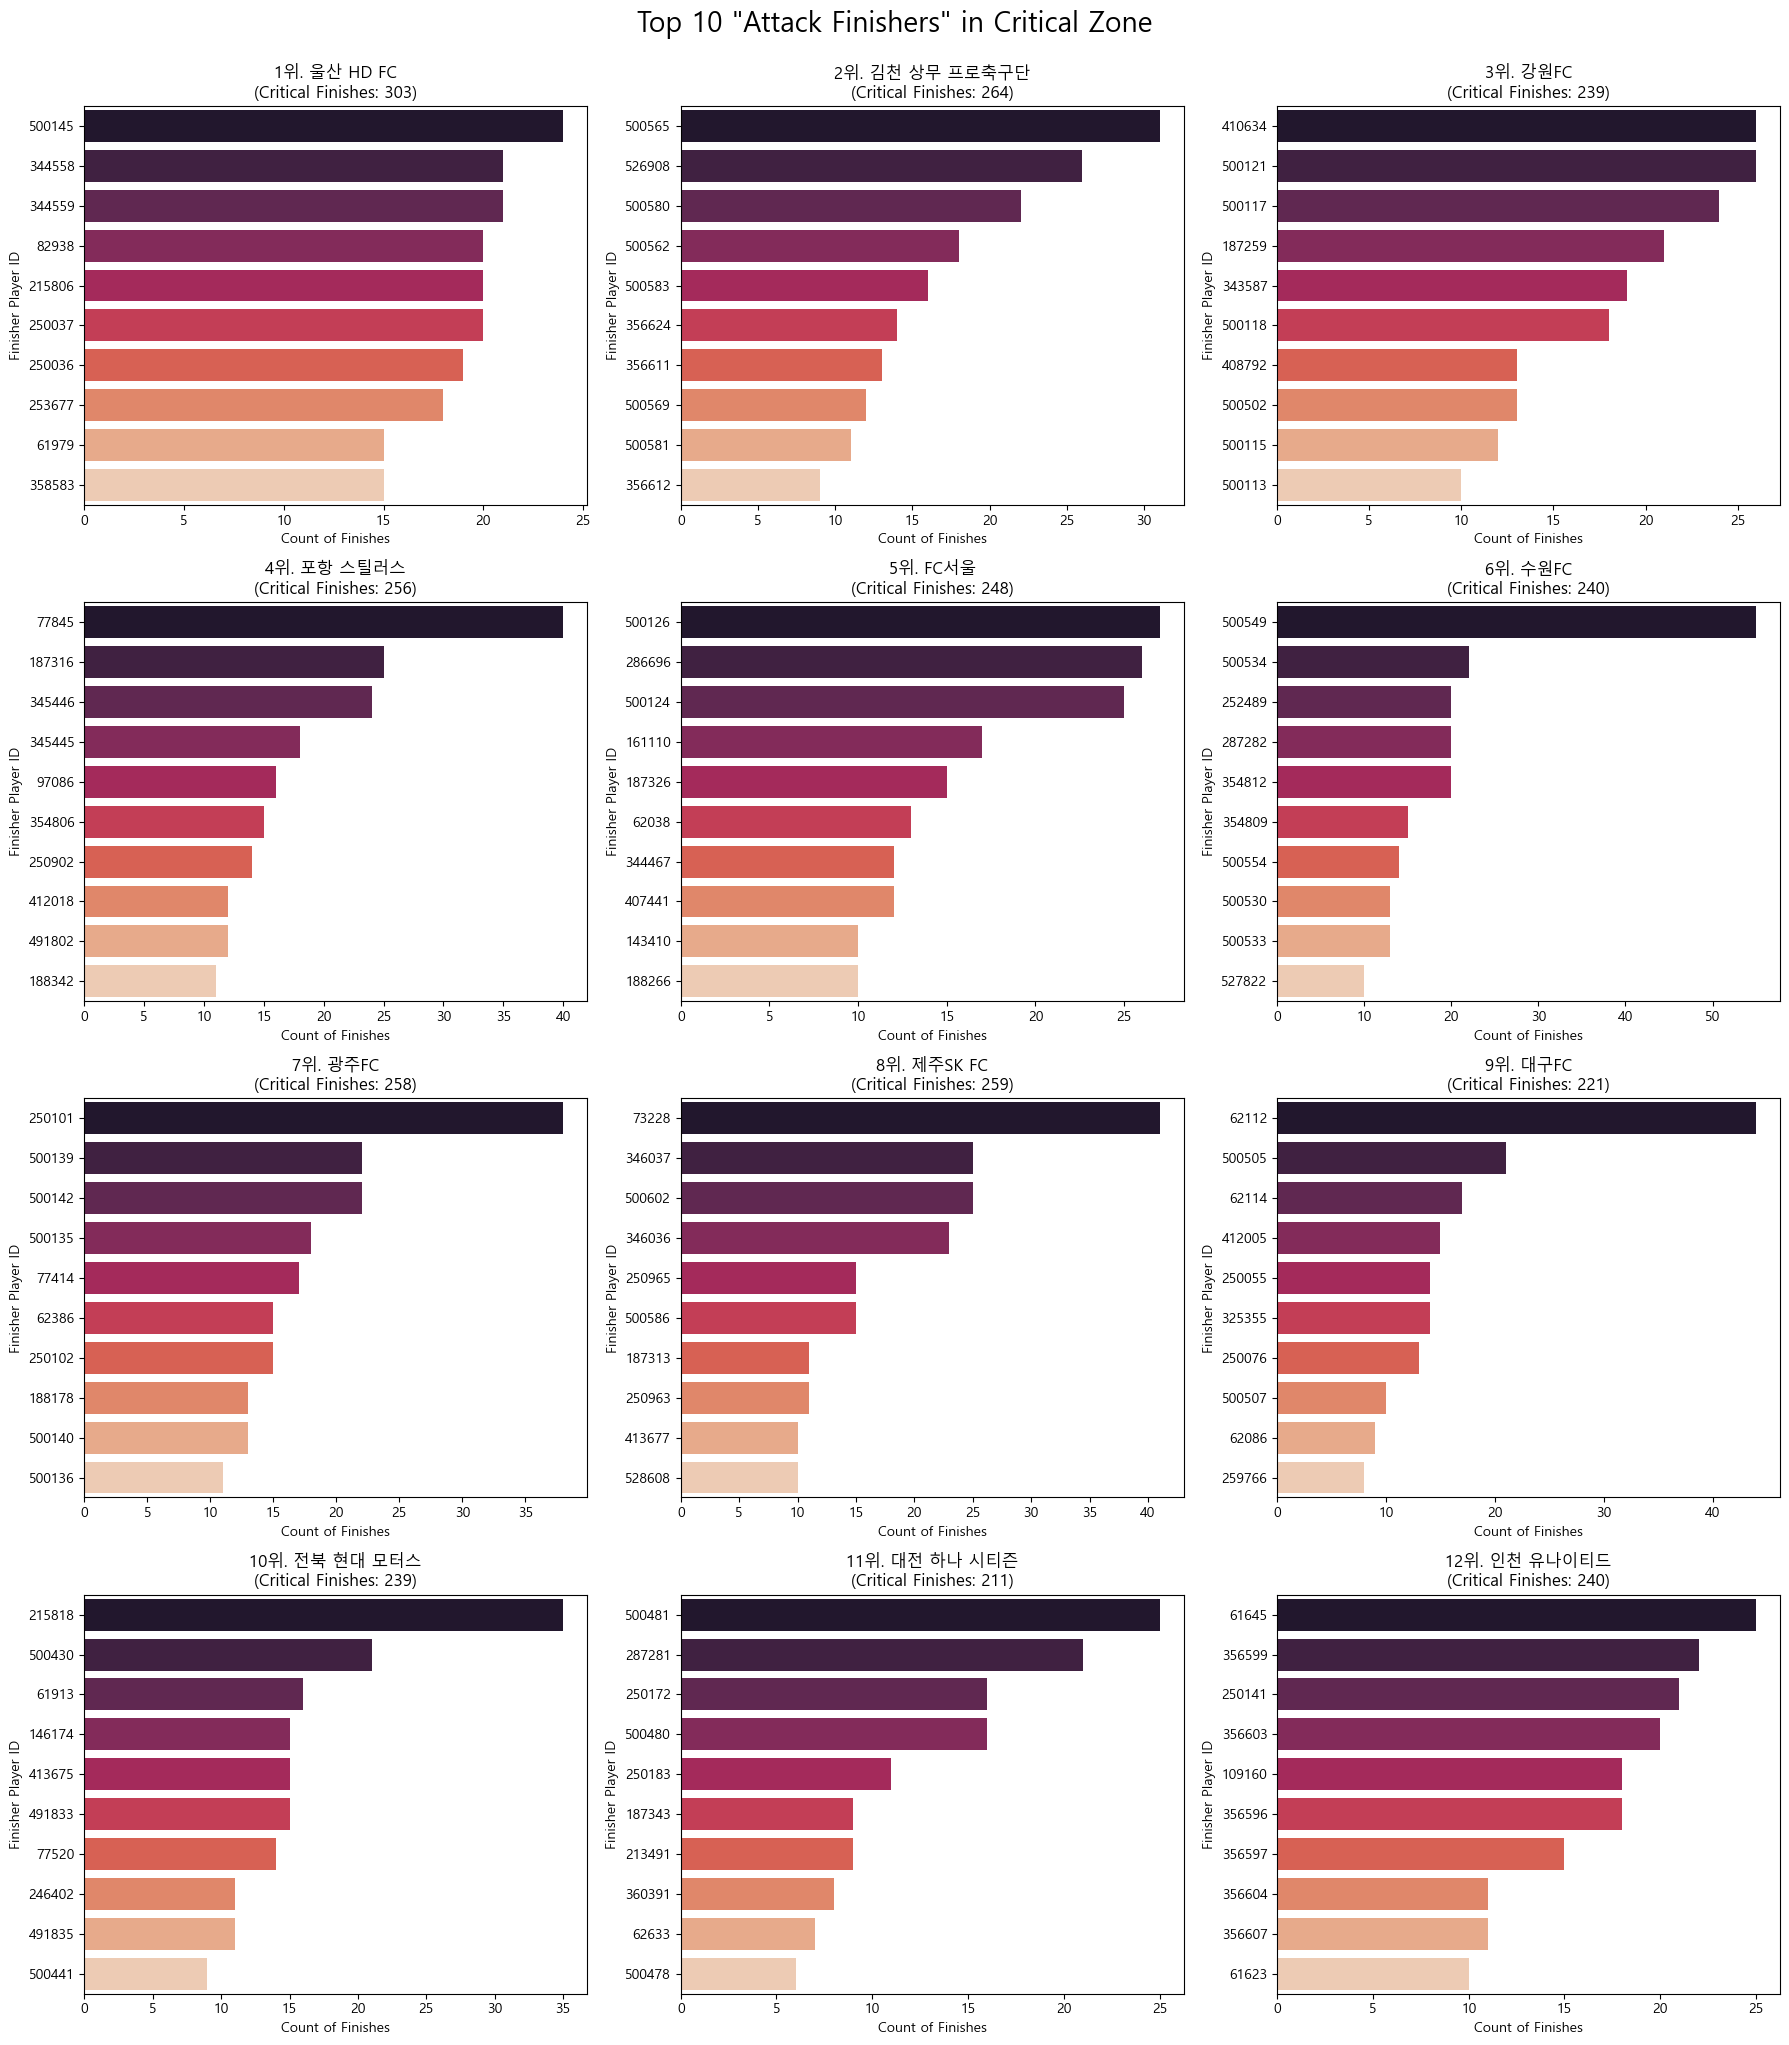

Total Critical Zone Finishes: 2978


In [27]:
episode_ends = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds']) \
                 .groupby(['game_id', 'period_id', 'episode_id']).last().reset_index()

# 3. 중요 지역에서 끝난 공격만 필터링
finishing_attacks = episode_ends[
    (episode_ends['end_x'] >= CRITICAL_X_MIN) &
    (episode_ends['end_y'] >= CRITICAL_Y_MIN) &
    (episode_ends['end_y'] <= CRITICAL_Y_MAX)
].copy()

# 4. 팀별, 선수별 마무리(Finisher) 통계 집계
finisher_stats = finishing_attacks.groupby(['team_name', 'player_id']).size().reset_index(name='count')
finisher_stats = finisher_stats.sort_values(['team_name', 'count'], ascending=[True, False])

# 5. 시각화 (12개 팀)
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

for i, team_name in enumerate(ordered_teams):
    ax = axes[i]
    
    # 해당 팀 데이터
    team_stats = finisher_stats[finisher_stats['team_name'] == team_name]
    total_finishes = team_stats['count'].sum()
    
    if team_stats.empty:
        ax.text(0.5, 0.5, 'No Data', ha='center')
        ax.set_title(f"{i+1}위. {team_name}\n(Finishes: 0)")
        continue
    
    # 상위 10명 추출
    top_finishers = team_stats.head(10)
    
    # Bar Plot
    sns.barplot(
        x='count', 
        y=top_finishers['player_id'].astype(str),
        hue=top_finishers['player_id'].astype(str),
        data=top_finishers, 
        ax=ax, 
        orient='h', 
        palette='rocket', # 강렬한 색상 (마무리 느낌)
        order=top_finishers['player_id'].astype(str),
        dodge=False
    )
    
    # Legend 제거
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    ax.set_title(f"{i+1}위. {team_name}\n(Critical Finishes: {total_finishes})")
    ax.set_xlabel('Count of Finishes')
    ax.set_ylabel('Finisher Player ID')

plt.tight_layout()
plt.suptitle('Top 10 "Attack Finishers" in Critical Zone', fontsize=20, y=1.02)
plt.show()

# (참고) 필터링된 공격 개수 출력
print(f"Total Critical Zone Finishes: {len(finishing_attacks)}")

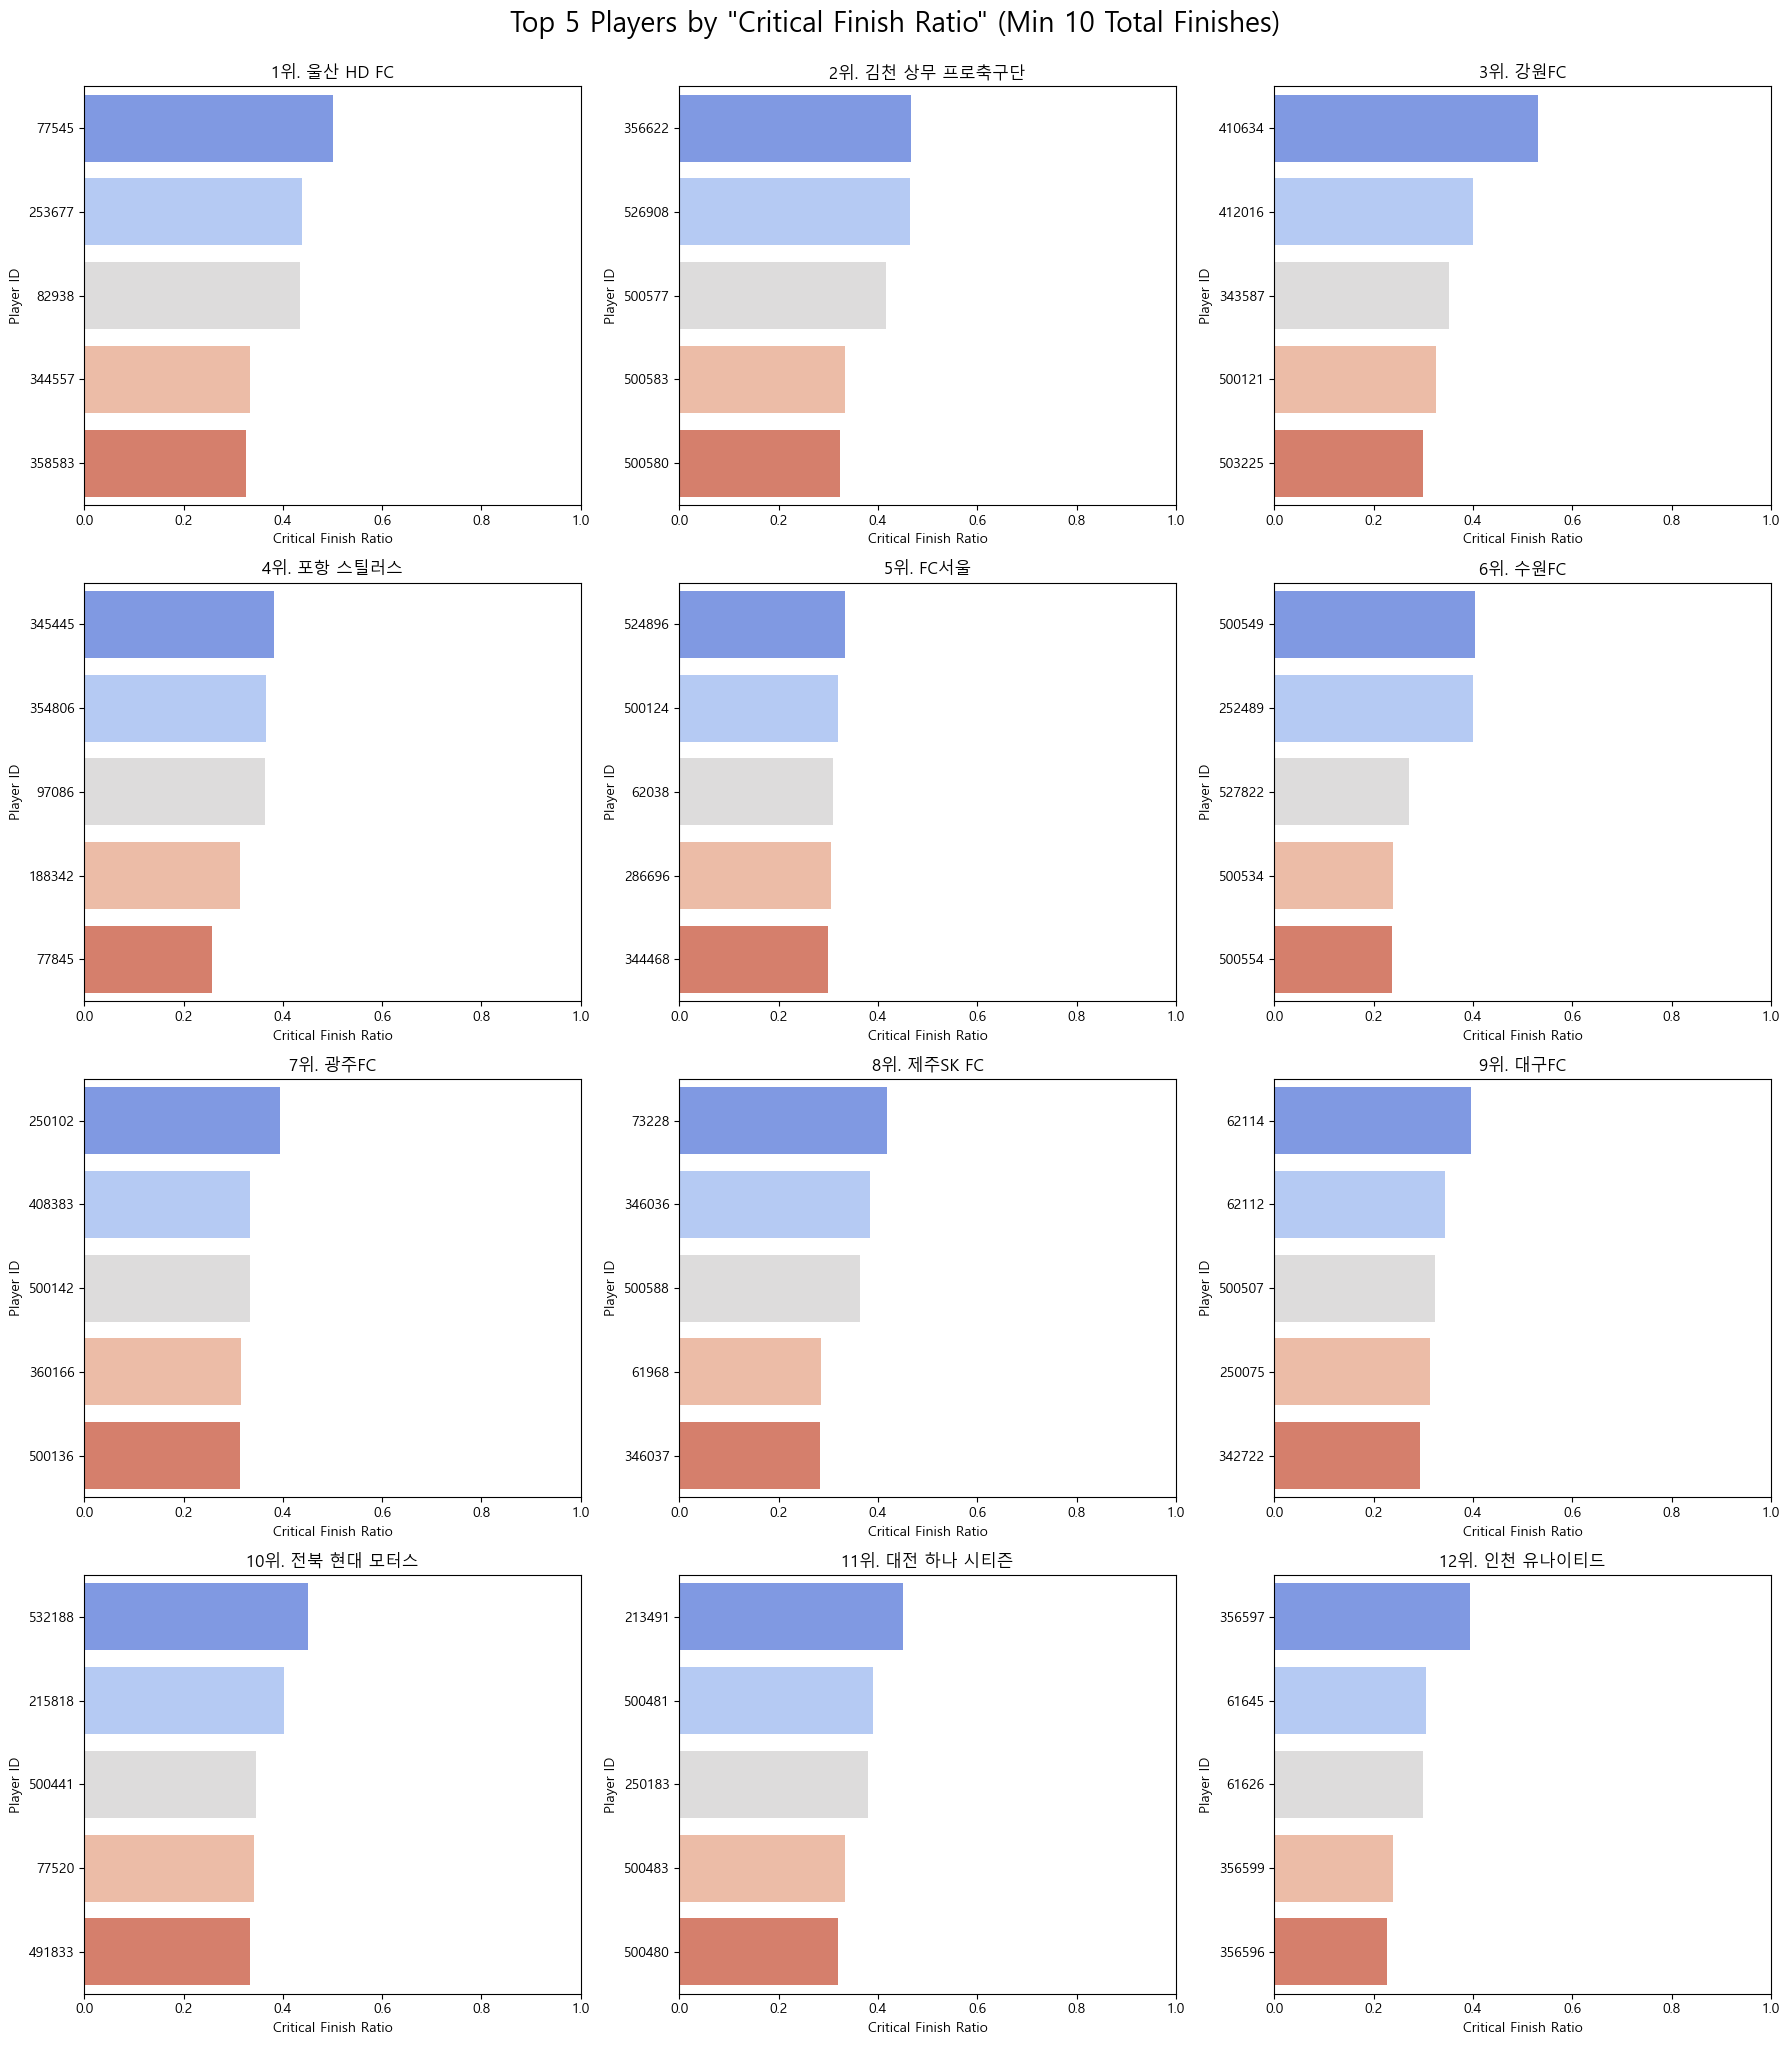

In [29]:
episode_ends['is_critical'] = (
    (episode_ends['end_x'] >= CRITICAL_X_MIN) & 
    (episode_ends['end_y'] >= CRITICAL_Y_MIN) & 
    (episode_ends['end_y'] <= CRITICAL_Y_MAX)
)

# 4. 선수별 비율 계산
# 최소 10회 이상 마무리를 한 선수만 대상으로 설정
stats = episode_ends.groupby(['team_name', 'player_id']).agg(
    total_finishes=('episode_id', 'count'),
    critical_finishes=('is_critical', 'sum')
).reset_index()

stats['ratio'] = stats['critical_finishes'] / stats['total_finishes']
filtered_stats = stats[stats['total_finishes'] >= 10].copy()
filtered_stats = filtered_stats.sort_values(['team_name', 'ratio'], ascending=[True, False])

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

for i, team_name in enumerate(ordered_teams):
    ax = axes[i]
    team_data = filtered_stats[filtered_stats['team_name'] == team_name]
    
    if team_data.empty:
        ax.text(0.5, 0.5, 'No Data (min 10 finishes)', ha='center')
        ax.set_title(f"{i+1}위. {team_name}")
        continue
    
    top_players = team_data.head(5)
    
    sns.barplot(
        x='ratio', 
        y=top_players['player_id'].astype(str),
        hue=top_players['player_id'].astype(str),
        data=top_players, 
        ax=ax, 
        orient='h', 
        palette='coolwarm',
        dodge=False
    )
    
    if ax.get_legend() is not None:
        ax.get_legend().remove()
        
    ax.set_xlim(0, 1.0)
    ax.set_title(f"{i+1}위. {team_name}")
    ax.set_xlabel('Critical Finish Ratio')
    ax.set_ylabel('Player ID')

plt.tight_layout()
plt.suptitle('Top 5 Players by "Critical Finish Ratio" (Min 10 Total Finishes)', fontsize=20, y=1.02)
plt.show()

ACtion 별 데이터 EDA

Counts by Start Action:
start_action
Recovery            17218
Interception         7937
Tackle               7403
Throw-In             6800
Duel                 5027
Pass                 4471
Block                3903
Pass_Freekick        3824
Intervention         3454
Goal Kick            2713
Pass_Corner          1137
Catch                 675
Carry                 661
Aerial Clearance      447
Error                 315
Parry                 216
Clearance             166
Cross                 107
Take-On                86
Shot                   57
Shot_Freekick          43
Hit                    37
Foul                   18
Deflection             14
Penalty Kick            2
Name: count, dtype: int64


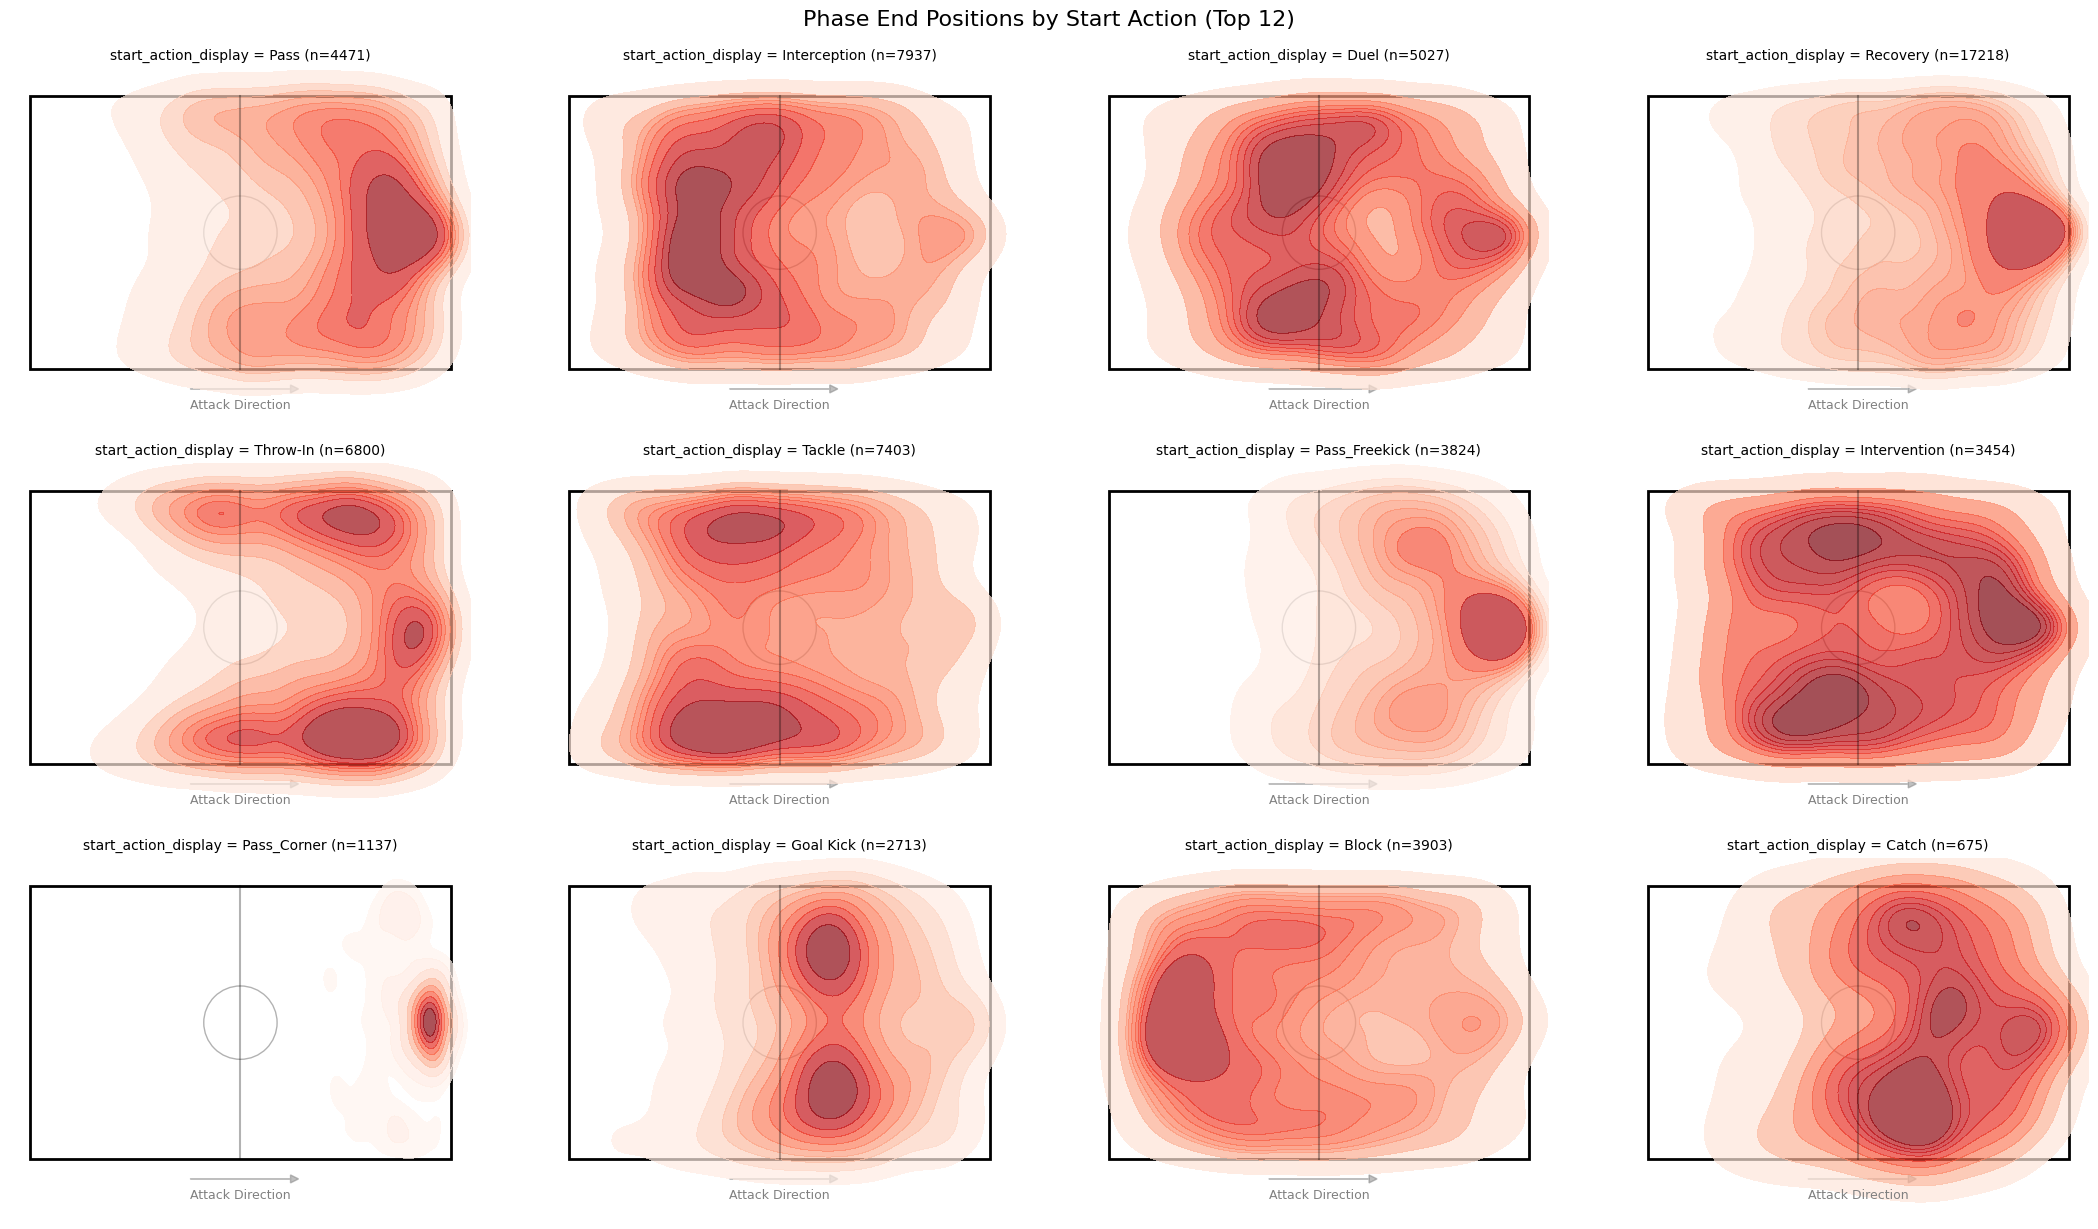

C:\Users\user\AppData\Local\Temp\ipykernel_12772\3588836003.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index, y=action_counts.values, palette='viridis')


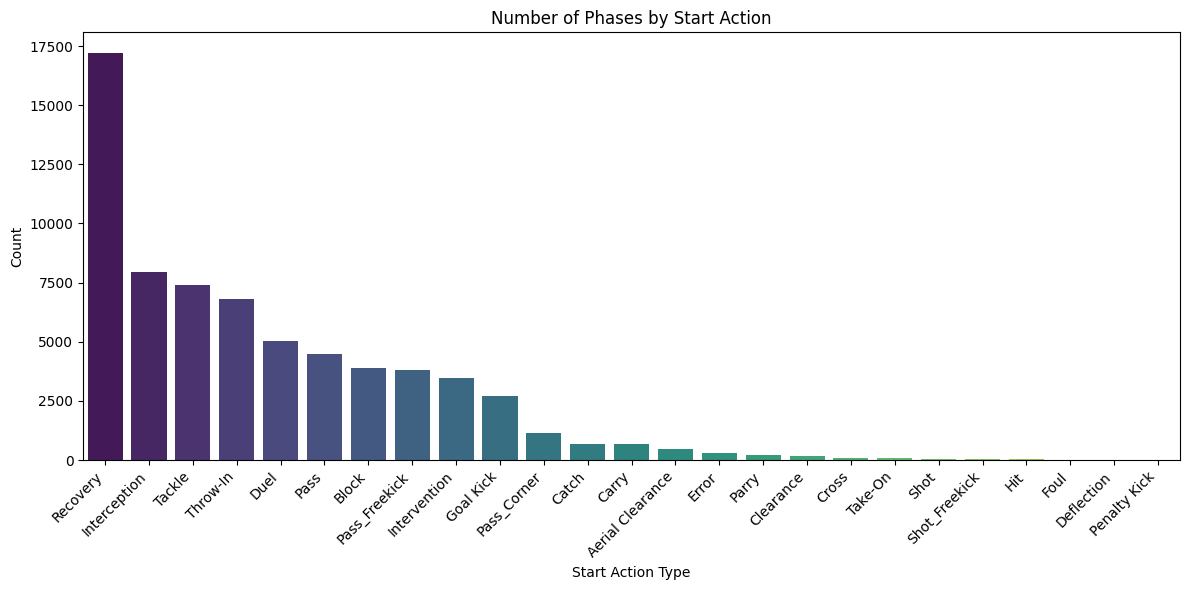

In [8]:
df = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds'])
df['unique_ep_id'] = df['game_id'].astype(str) + '_' + df['period_id'].astype(str) + '_' + df['episode_id'].astype(str)
is_new_episode = df['unique_ep_id'] != df['unique_ep_id'].shift()
is_team_change = df['team_id'] != df['team_id'].shift()
df['phase_id'] = (is_new_episode | is_team_change).cumsum()

# 3. Aggregate by Phase
phase_summary = df.groupby('phase_id').agg(
    start_action=('type_name', 'first'),
    end_x=('end_x', 'last'),
    end_y=('end_y', 'last'),
    count=('action_id', 'count')
).reset_index()

# 4. Count Data by Start Action
action_counts = phase_summary['start_action'].value_counts()
print("Counts by Start Action:")
print(action_counts)

# 5. Visualization
# Select top 12 actions for visualization to keep it readable
top_actions = action_counts.head(12).index.tolist()
filtered_data = phase_summary[phase_summary['start_action'].isin(top_actions)].copy()

# Add count to the action name for display
filtered_data['start_action_display'] = filtered_data['start_action'].apply(
    lambda x: f"{x} (n={action_counts[x]})"
)

def draw_pitch(ax):
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_kde_on_pitch(x, y, **kwargs):
    ax = plt.gca()
    draw_pitch(ax)
    if len(x) > 10: # Avoid error for very small datasets
        sns.kdeplot(x=x, y=y, fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=ax)
    else:
        ax.text(52.5, 34, "Not enough data", ha='center')

# Create FacetGrid
g = sns.FacetGrid(filtered_data, col="start_action_display", col_wrap=4, height=4, aspect=1.4)
g.map(plot_kde_on_pitch, "end_x", "end_y")
g.fig.suptitle(f"Phase End Positions by Start Action (Top {len(top_actions)})", fontsize=16, y=1.02)
plt.show()

# Visualize Counts (Bar Chart)
plt.figure(figsize=(12, 6))
sns.barplot(x=action_counts.index, y=action_counts.values, palette='viridis')
plt.title("Number of Phases by Start Action")
plt.xlabel("Start Action Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

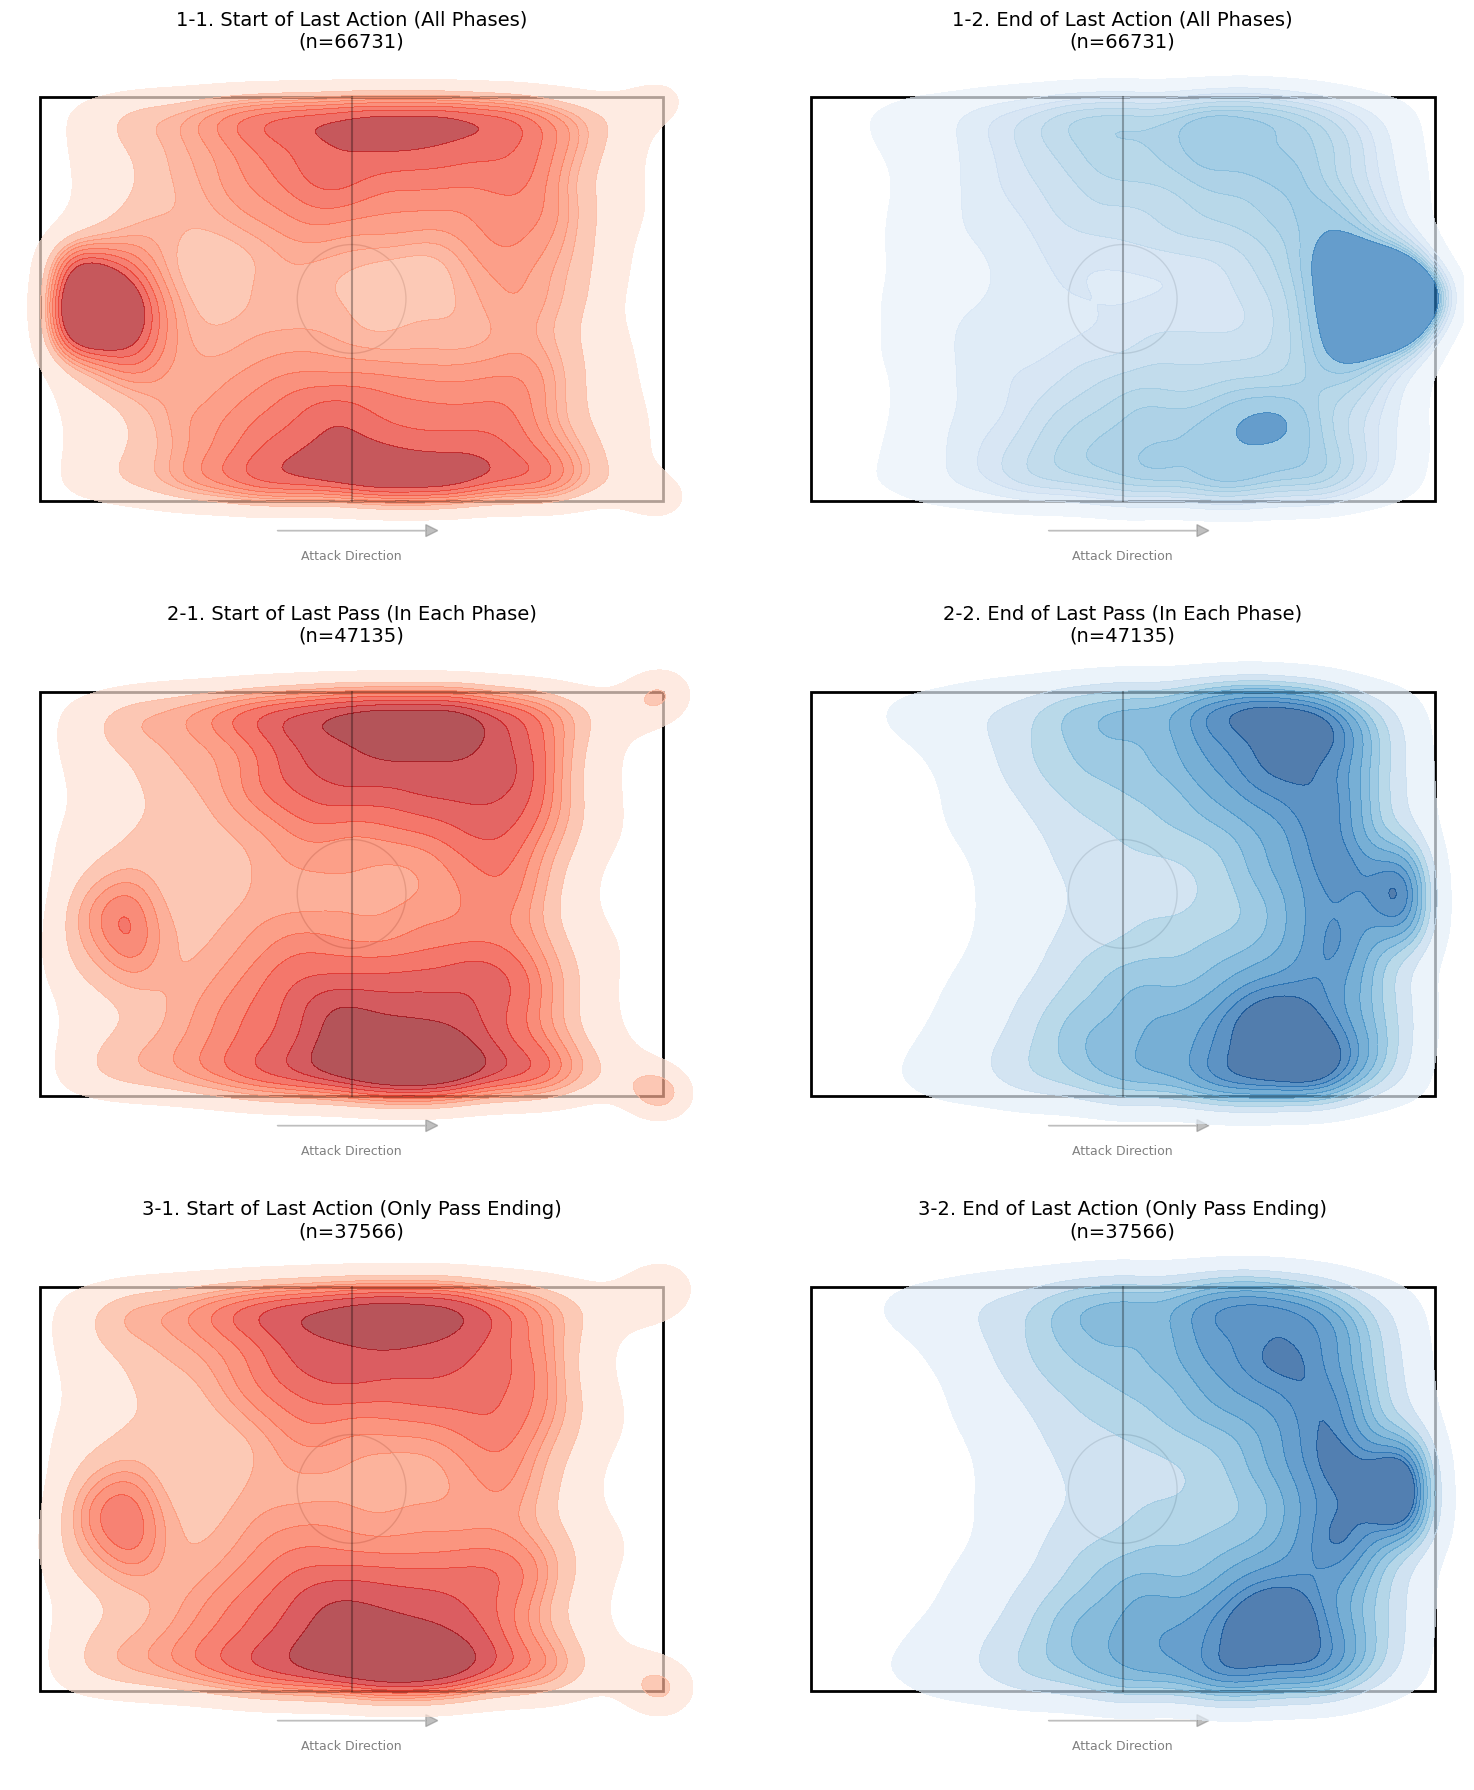

=== 데이터 개수 확인 ===
1. 전체 Phase 개수: 66731
2. 패스가 하나라도 포함된 Phase 개수: 47135
3. 패스로 종료된 Phase 개수: 37566


In [15]:
df = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds', 'action_id'])

df['unique_ep_id'] = df['game_id'].astype(str) + '_' + df['period_id'].astype(str) + '_' + df['episode_id'].astype(str)

# Phase ID 생성 (에피소드 변경 OR 팀 변경)
is_new_episode = df['unique_ep_id'] != df['unique_ep_id'].shift()
is_team_change = df['team_id'] != df['team_id'].shift()
df['phase_id'] = (is_new_episode | is_team_change).cumsum()

# ---------------------------------------------------------
# 3. 데이터 추출
# ---------------------------------------------------------

# (Set 1) 각 Phase의 '마지막 Action' 데이터
last_actions = df.groupby('phase_id').last().reset_index()

# (Set 2) 각 Phase 내의 '마지막 Pass' 데이터
# 패스 관련 이벤트만 필터링
pass_events = df[df['type_name'].str.contains('Pass', case=False, na=False)]
last_passes = pass_events.groupby('phase_id').last().reset_index()

# (Set 3) '마지막 Action'이 Pass인 경우만 필터링
# Set 1에서 type_name이 Pass인 것들
pass_ending_phases = last_actions[last_actions['type_name'].str.contains('Pass', case=False, na=False)]


# ---------------------------------------------------------
# 4. 시각화 (3행 2열)
# ---------------------------------------------------------

def draw_pitch(ax):
    # 경기장 외곽선 및 라인
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    
    # 공격 방향 표시 (L -> R)
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

# 3행 2열 서브플롯 생성
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# --- Row 1: 각 Phase의 마지막 Action (Start vs End) ---
# 왼쪽: Start
draw_pitch(axes[0, 0])
sns.kdeplot(x=last_actions['start_x'], y=last_actions['start_y'], fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=axes[0, 0])
axes[0, 0].set_title(f"1-1. Start of Last Action (All Phases)\n(n={len(last_actions)})", fontsize=14)

# 오른쪽: End
draw_pitch(axes[0, 1])
sns.kdeplot(x=last_actions['end_x'], y=last_actions['end_y'], fill=True, cmap='Blues', thresh=0.05, alpha=0.7, ax=axes[0, 1])
axes[0, 1].set_title(f"1-2. End of Last Action (All Phases)\n(n={len(last_actions)})", fontsize=14)


# --- Row 2: 각 Phase의 마지막 Pass (Start vs End) ---
# 왼쪽: Start
draw_pitch(axes[1, 0])
if not last_passes.empty:
    sns.kdeplot(x=last_passes['start_x'], y=last_passes['start_y'], fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=axes[1, 0])
axes[1, 0].set_title(f"2-1. Start of Last Pass (In Each Phase)\n(n={len(last_passes)})", fontsize=14)

# 오른쪽: End
draw_pitch(axes[1, 1])
if not last_passes.empty:
    sns.kdeplot(x=last_passes['end_x'], y=last_passes['end_y'], fill=True, cmap='Blues', thresh=0.05, alpha=0.7, ax=axes[1, 1])
axes[1, 1].set_title(f"2-2. End of Last Pass (In Each Phase)\n(n={len(last_passes)})", fontsize=14)


# --- Row 3: 마지막 Action이 Pass인 경우 (Start vs End) ---
# 왼쪽: Start
draw_pitch(axes[2, 0])
if not pass_ending_phases.empty:
    sns.kdeplot(x=pass_ending_phases['start_x'], y=pass_ending_phases['start_y'], fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=axes[2, 0])
axes[2, 0].set_title(f"3-1. Start of Last Action (Only Pass Ending)\n(n={len(pass_ending_phases)})", fontsize=14)

# 오른쪽: End
draw_pitch(axes[2, 1])
if not pass_ending_phases.empty:
    sns.kdeplot(x=pass_ending_phases['end_x'], y=pass_ending_phases['end_y'], fill=True, cmap='Blues', thresh=0.05, alpha=0.7, ax=axes[2, 1])
axes[2, 1].set_title(f"3-2. End of Last Action (Only Pass Ending)\n(n={len(pass_ending_phases)})", fontsize=14)

plt.tight_layout()
plt.show()

# 간단한 통계 출력
print("=== 데이터 개수 확인 ===")
print(f"1. 전체 Phase 개수: {len(last_actions)}")
print(f"2. 패스가 하나라도 포함된 Phase 개수: {len(last_passes)}")
print(f"3. 패스로 종료된 Phase 개수: {len(pass_ending_phases)}")

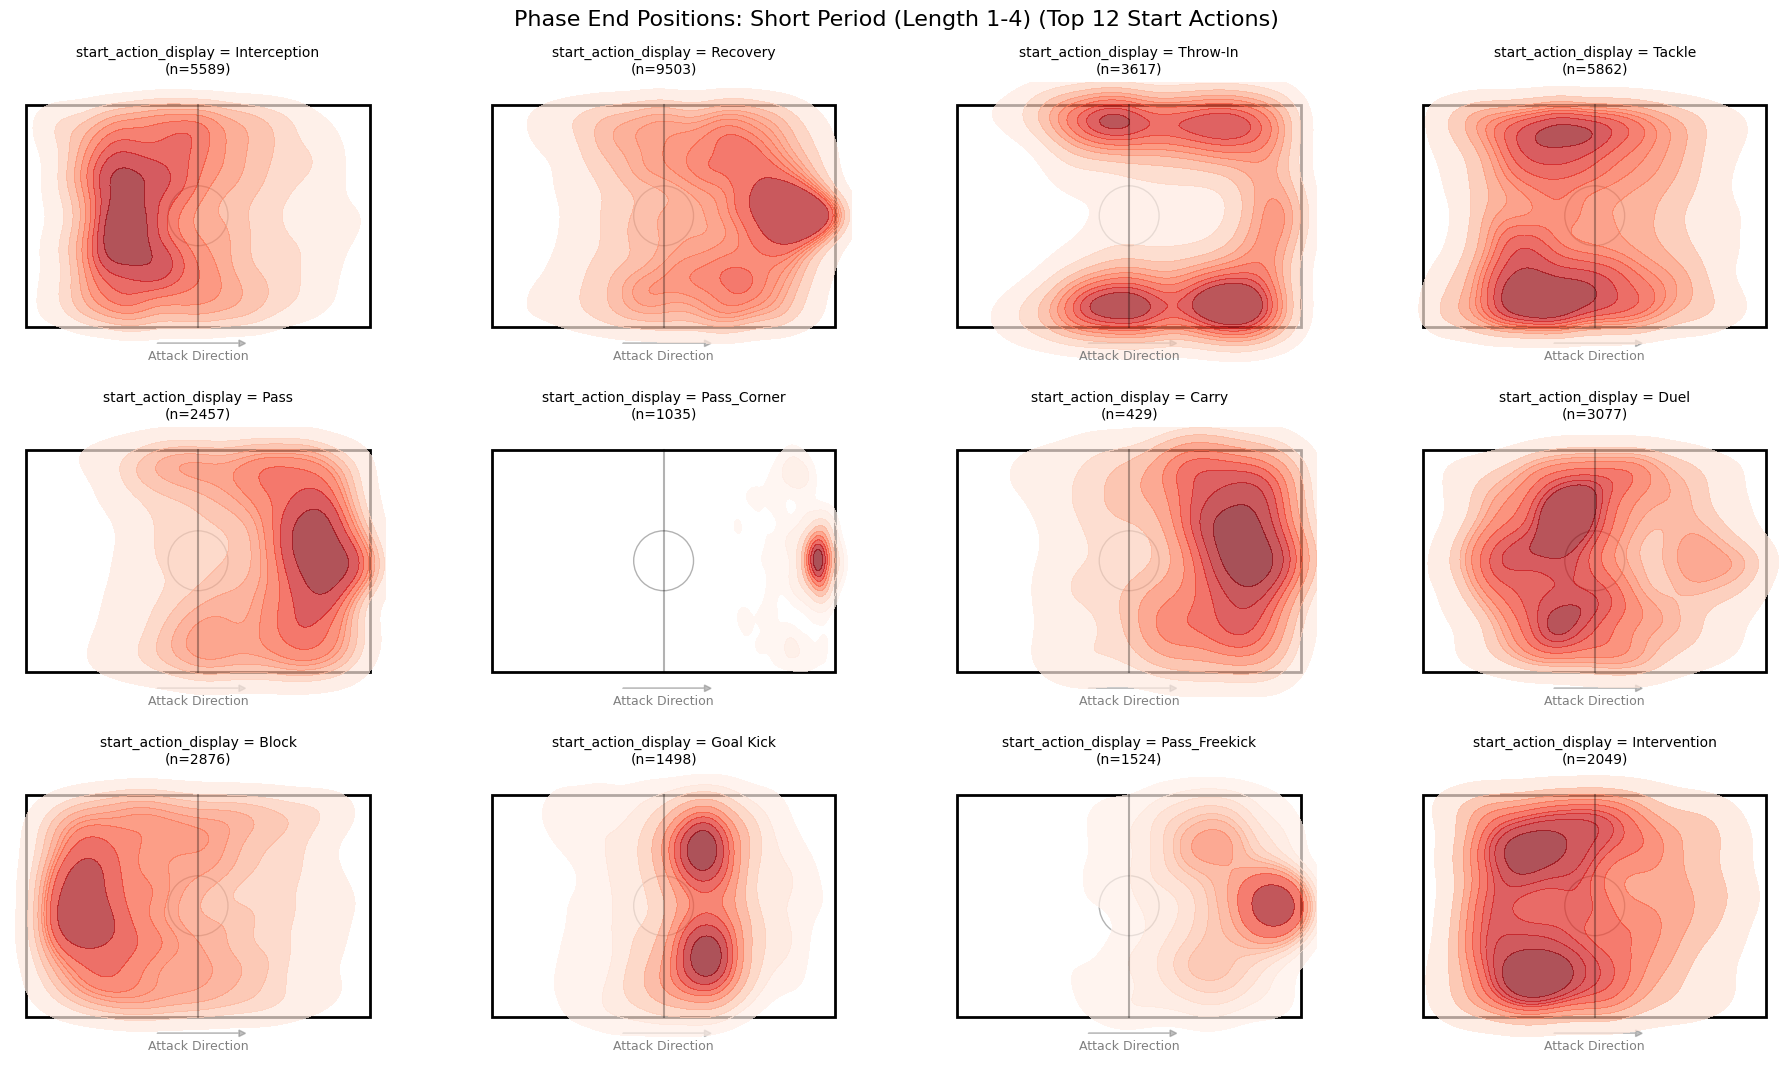


=== Top 12 Start Actions for Short Period (Length 1-4) ===
start_action
Recovery         9503
Tackle           5862
Interception     5589
Throw-In         3617
Duel             3077
Block            2876
Pass             2457
Intervention     2049
Pass_Freekick    1524
Goal Kick        1498
Pass_Corner      1035
Carry             429
Name: count, dtype: int64


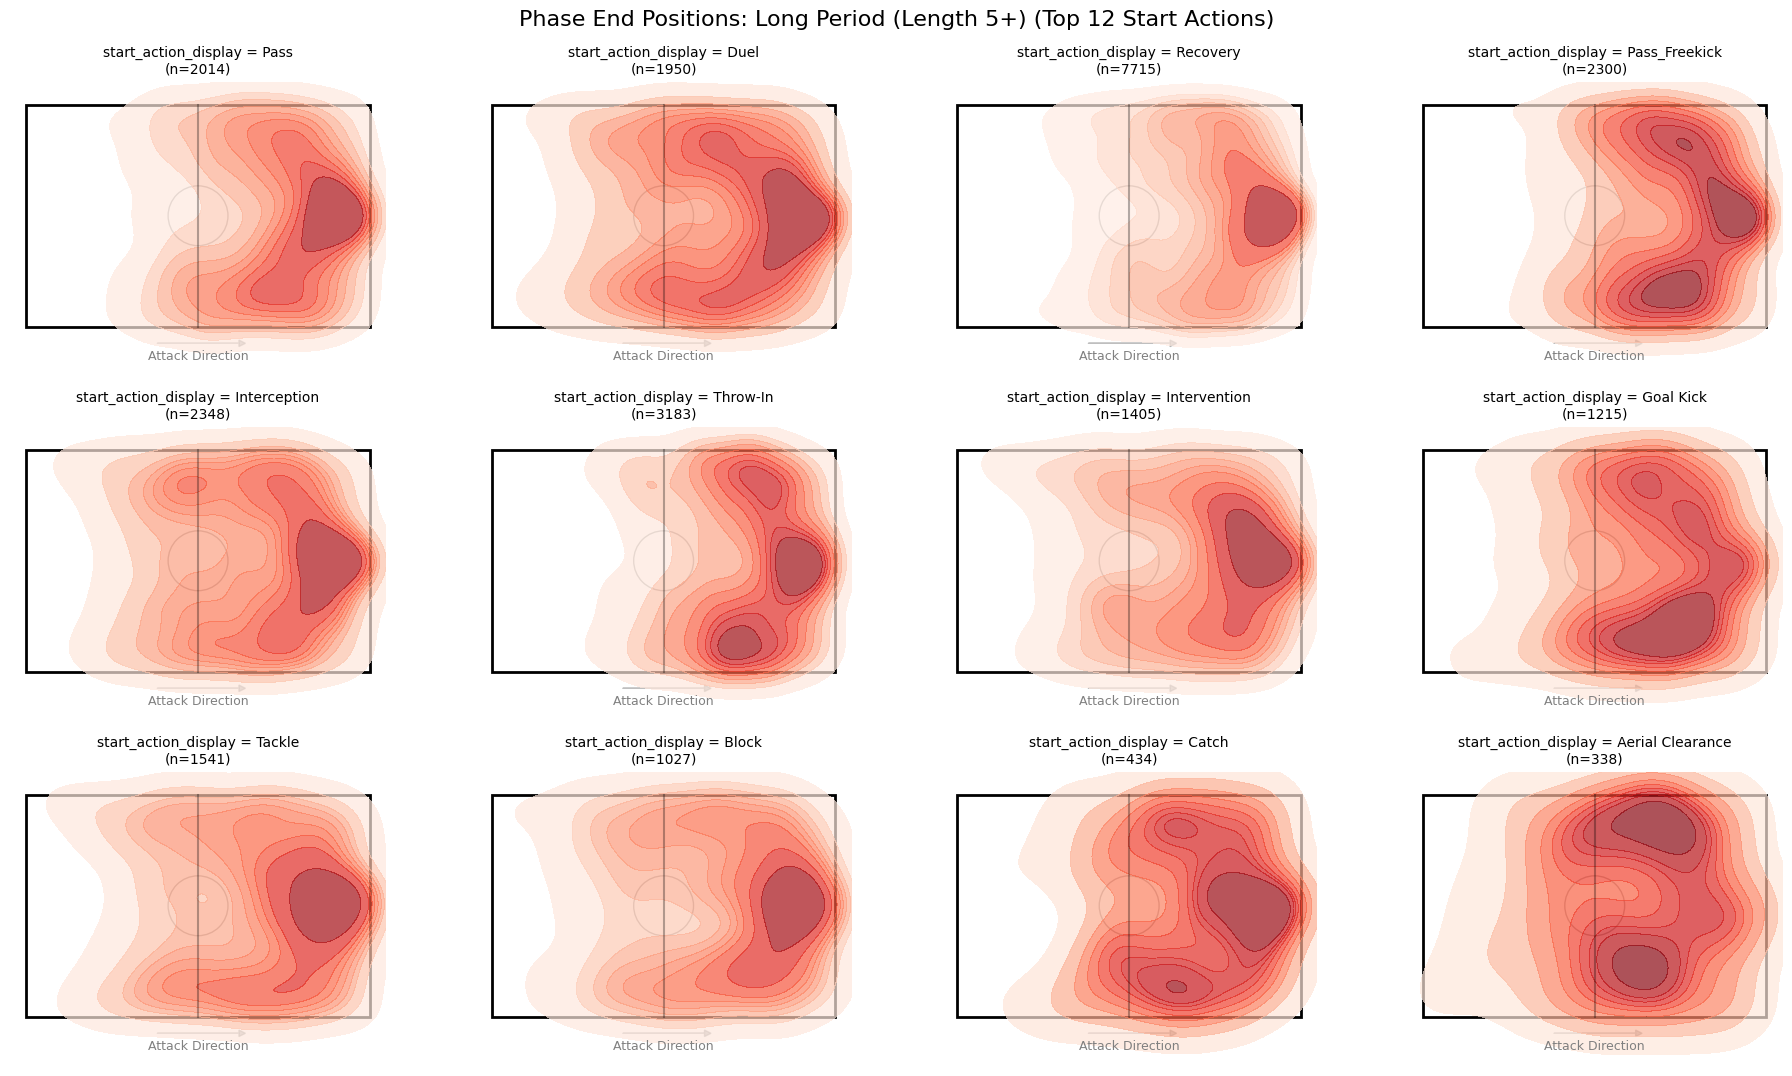


=== Top 12 Start Actions for Long Period (Length 5+) ===
start_action
Recovery            7715
Throw-In            3183
Interception        2348
Pass_Freekick       2300
Pass                2014
Duel                1950
Tackle              1541
Intervention        1405
Goal Kick           1215
Block               1027
Catch                434
Aerial Clearance     338
Name: count, dtype: int64


In [22]:
# 2. 전처리: 정렬 및 Phase 정의
# [중요] action_id를 정렬 기준에 포함하여 순서 오류 방지
df = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds', 'action_id'])

# 고유 에피소드 ID
df['unique_ep_id'] = df['game_id'].astype(str) + '_' + df['period_id'].astype(str) + '_' + df['episode_id'].astype(str)

# Phase ID 생성
is_new_episode = df['unique_ep_id'] != df['unique_ep_id'].shift()
is_team_change = df['team_id'] != df['team_id'].shift()
df['phase_id'] = (is_new_episode | is_team_change).cumsum()

# 3. Phase 단위 데이터 집계
phase_summary = df.groupby('phase_id').agg(
    start_action=('type_name', 'first'),
    end_x=('end_x', 'last'),
    end_y=('end_y', 'last'),
    count=('action_id', 'count') # Phase 길이
).reset_index()

# 4. Phase 길이 분류 (Short: 1~5, Long: 6~)
phase_summary['length_type'] = phase_summary['count'].apply(lambda x: 'Short (1-4)' if x <= 4 else 'Long (5+)')

# ---------------------------------------------------------
# 5. 시각화 함수 정의
# ---------------------------------------------------------
def draw_pitch(ax):
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_kde_on_pitch(x, y, **kwargs):
    ax = plt.gca()
    draw_pitch(ax)
    if len(x) > 10: 
        sns.kdeplot(x=x, y=y, fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=ax)
    else:
        # 데이터가 너무 적으면 산점도로 대체
        ax.scatter(x, y, color='red', s=10, alpha=0.5)
        if len(x) == 0:
            ax.text(52.5, 34, "No Data", ha='center')

def visualize_phase_group(data, group_name):
    # 해당 그룹에서 빈도수 상위 12개 행동 추출
    action_counts = data['start_action'].value_counts()
    top_actions = action_counts.head(12).index.tolist()
    
    # 상위 12개 행동만 필터링
    filtered_data = data[data['start_action'].isin(top_actions)].copy()
    
    # 라벨에 빈도수 추가
    filtered_data['start_action_display'] = filtered_data['start_action'].apply(
        lambda x: f"{x}\n(n={action_counts[x]})"
    )
    
    # FacetGrid 시각화
    g = sns.FacetGrid(filtered_data, col="start_action_display", col_wrap=4, height=3.5, aspect=1.4)
    g.map(plot_kde_on_pitch, "end_x", "end_y")
    
    g.fig.suptitle(f"Phase End Positions: {group_name} (Top 12 Start Actions)", fontsize=16, y=1.02)
    plt.show()
    
    # 텍스트로도 출력
    print(f"\n=== Top 12 Start Actions for {group_name} ===")
    print(action_counts.head(12))

# ---------------------------------------------------------
# 6. 실행 (Short vs Long)
# ---------------------------------------------------------

# (1) Short Phase 시각화
short_data = phase_summary[phase_summary['length_type'] == 'Short (1-4)']
visualize_phase_group(short_data, 'Short Period (Length 1-4)')

# (2) Long Phase 시각화
long_data = phase_summary[phase_summary['length_type'] == 'Long (5+)']
visualize_phase_group(long_data, 'Long Period (Length 5+)')

ACtion 별 데이터 EDA (Episode)

전체 에피소드 개수: 15435
Pass로 종료된 에피소드: 15434
Pass가 아닌 것으로 종료된 에피소드: 1

[Pass가 아닌 마지막 이벤트 정보]
      unique_ep_id type_name result_name   start_x    start_y      end_x  \
13018  126451_1_18     Carry  Successful  48.84936  67.318939  61.276635   

           end_y  
13018  57.771644  


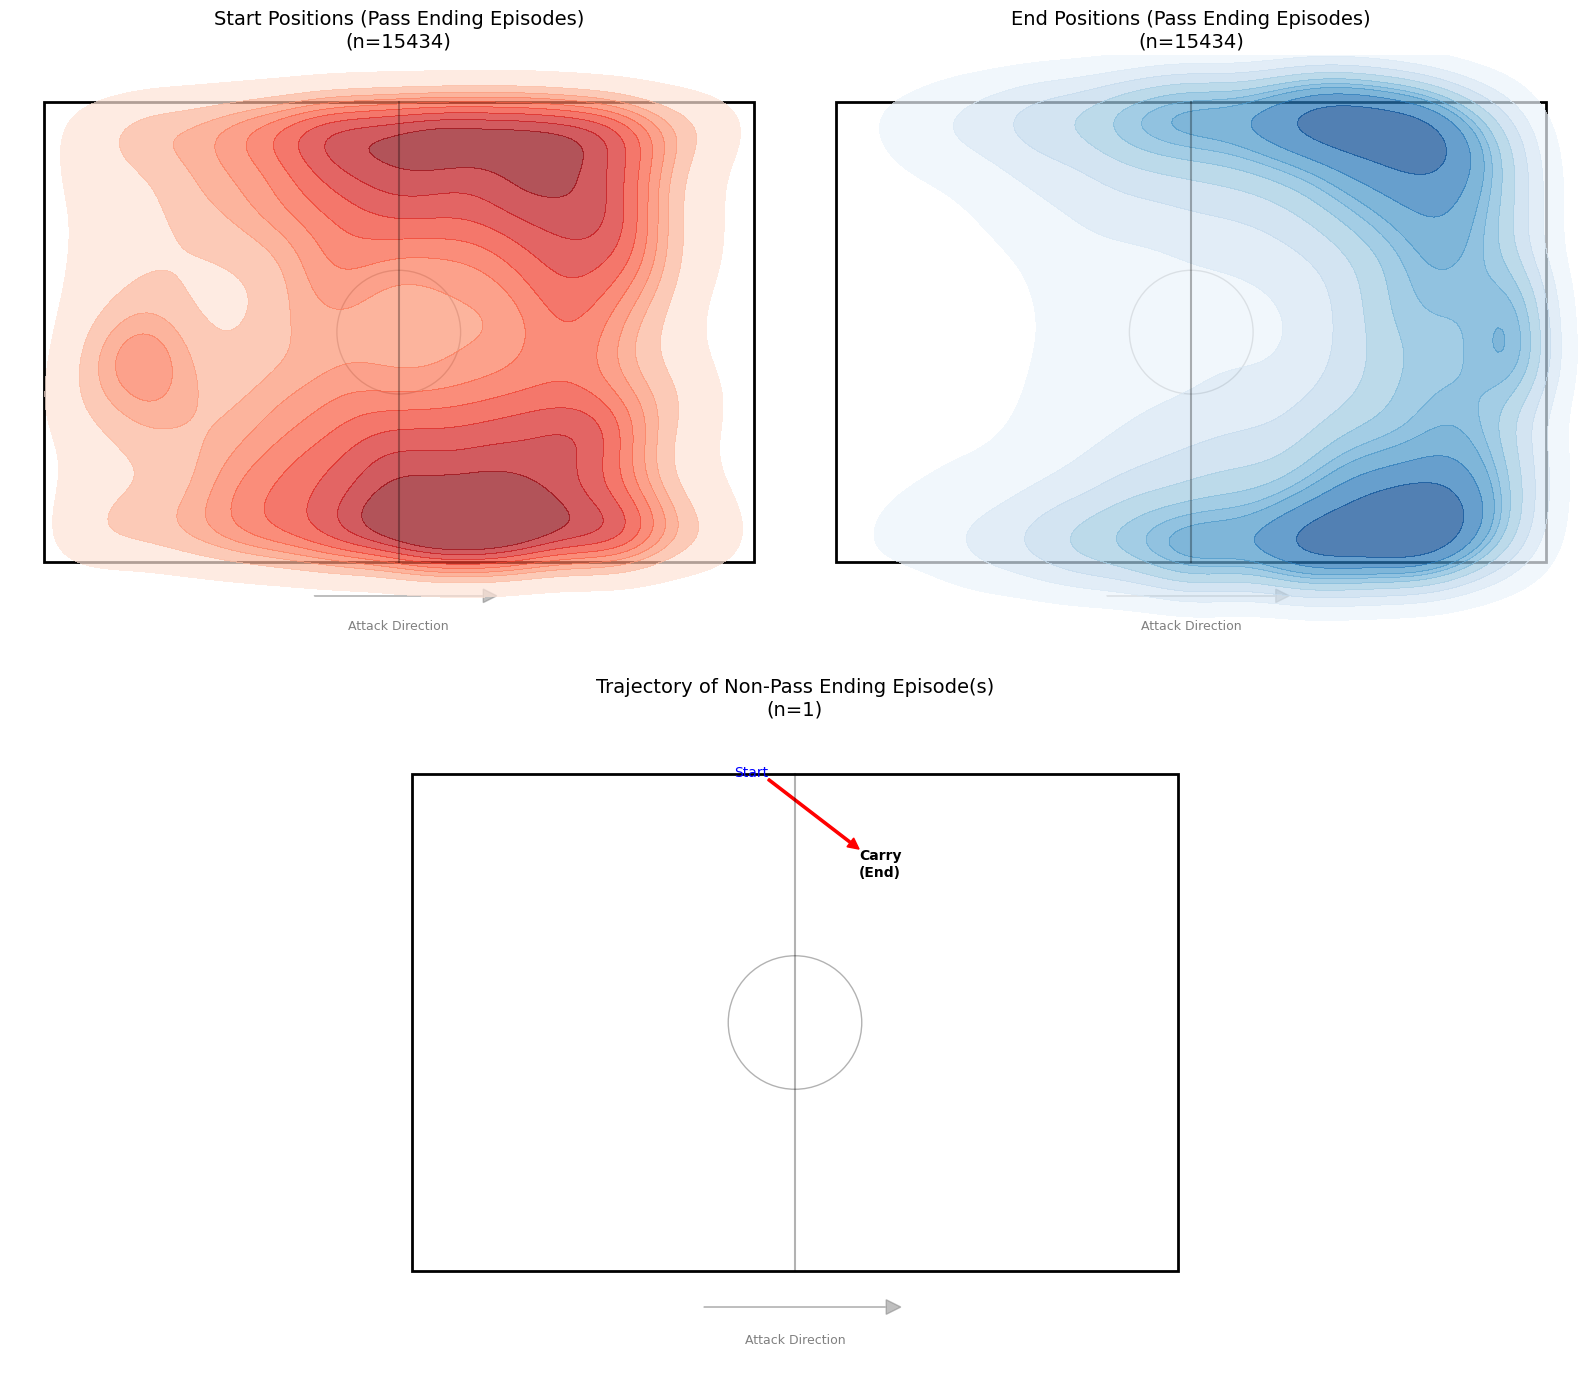

In [14]:
# 2. 전처리: 에피소드 기준 그룹화
# 시간 순 정렬
df = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds'])

# 고유 에피소드 ID 생성 (Game - Period - Episode)
df['unique_ep_id'] = df['game_id'].astype(str) + '_' + df['period_id'].astype(str) + '_' + df['episode_id'].astype(str)

# 각 에피소드의 '마지막 Action' 추출
last_actions = df.groupby('unique_ep_id').last().reset_index()

# 3. 데이터 분리 (Pass로 끝난 것 vs 아닌 것)
# type_name에 'Pass'가 포함되면 Pass 종료로 간주
is_pass_ending = last_actions['type_name'].str.contains('Pass', case=False, na=False)

pass_end_df = last_actions[is_pass_ending]
non_pass_end_df = last_actions[~is_pass_ending]

# 4. 결과 출력 (Non-Pass 에피소드 정보)
print(f"전체 에피소드 개수: {len(last_actions)}")
print(f"Pass로 종료된 에피소드: {len(pass_end_df)}")
print(f"Pass가 아닌 것으로 종료된 에피소드: {len(non_pass_end_df)}")

if not non_pass_end_df.empty:
    print("\n[Pass가 아닌 마지막 이벤트 정보]")
    print(non_pass_end_df[['unique_ep_id', 'type_name', 'result_name', 'start_x', 'start_y', 'end_x', 'end_y']])
else:
    print("\nPass가 아닌 것으로 종료된 에피소드가 없습니다.")


# 5. 시각화
def draw_pitch(ax):
    # 경기장 외곽선 및 라인
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    
    # 공격 방향
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

# 그래프 배치: 
# Row 1: Pass 종료 에피소드 (Start 분포, End 분포) -> 2개
# Row 2: Non-Pass 종료 에피소드 (단일 궤적) -> 1개 (중앙 배치)
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(2, 2)

# --- [Row 1] Pass로 종료된 에피소드 (Start vs End) ---
ax1 = fig.add_subplot(gs[0, 0])
draw_pitch(ax1)
sns.kdeplot(x=pass_end_df['start_x'], y=pass_end_df['start_y'], fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=ax1)
ax1.set_title(f"Start Positions (Pass Ending Episodes)\n(n={len(pass_end_df)})", fontsize=14)

ax2 = fig.add_subplot(gs[0, 1])
draw_pitch(ax2)
sns.kdeplot(x=pass_end_df['end_x'], y=pass_end_df['end_y'], fill=True, cmap='Blues', thresh=0.05, alpha=0.7, ax=ax2)
ax2.set_title(f"End Positions (Pass Ending Episodes)\n(n={len(pass_end_df)})", fontsize=14)


# --- [Row 2] Pass가 아닌 에피소드 (개별 궤적 시각화) ---
ax3 = fig.add_subplot(gs[1, :]) # 하단 전체 사용
draw_pitch(ax3)

if not non_pass_end_df.empty:
    # 화살표로 궤적 그리기
    for _, row in non_pass_end_df.iterrows():
        # 시작점 -> 끝점 화살표
        ax3.arrow(row['start_x'], row['start_y'], 
                  row['end_x'] - row['start_x'], row['end_y'] - row['start_y'],
                  head_width=1.5, head_length=1.5, fc='red', ec='red', length_includes_head=True, width=0.3)
        
        # 시작점(S)과 끝점(E) 텍스트 표시
        ax3.text(row['start_x'], row['start_y'], 'Start', color='blue', fontsize=10, ha='right', va='bottom')
        ax3.text(row['end_x'], row['end_y'], f"{row['type_name']}\n(End)", color='black', fontsize=10, fontweight='bold', ha='left', va='top')
        
    ax3.set_title(f"Trajectory of Non-Pass Ending Episode(s)\n(n={len(non_pass_end_df)})", fontsize=14)
else:
    ax3.text(52.5, 34, "No Non-Pass Ending Episodes Found", ha='center', fontsize=14)
    ax3.set_title("Non-Pass Ending Episodes", fontsize=14)

plt.tight_layout()
plt.show()

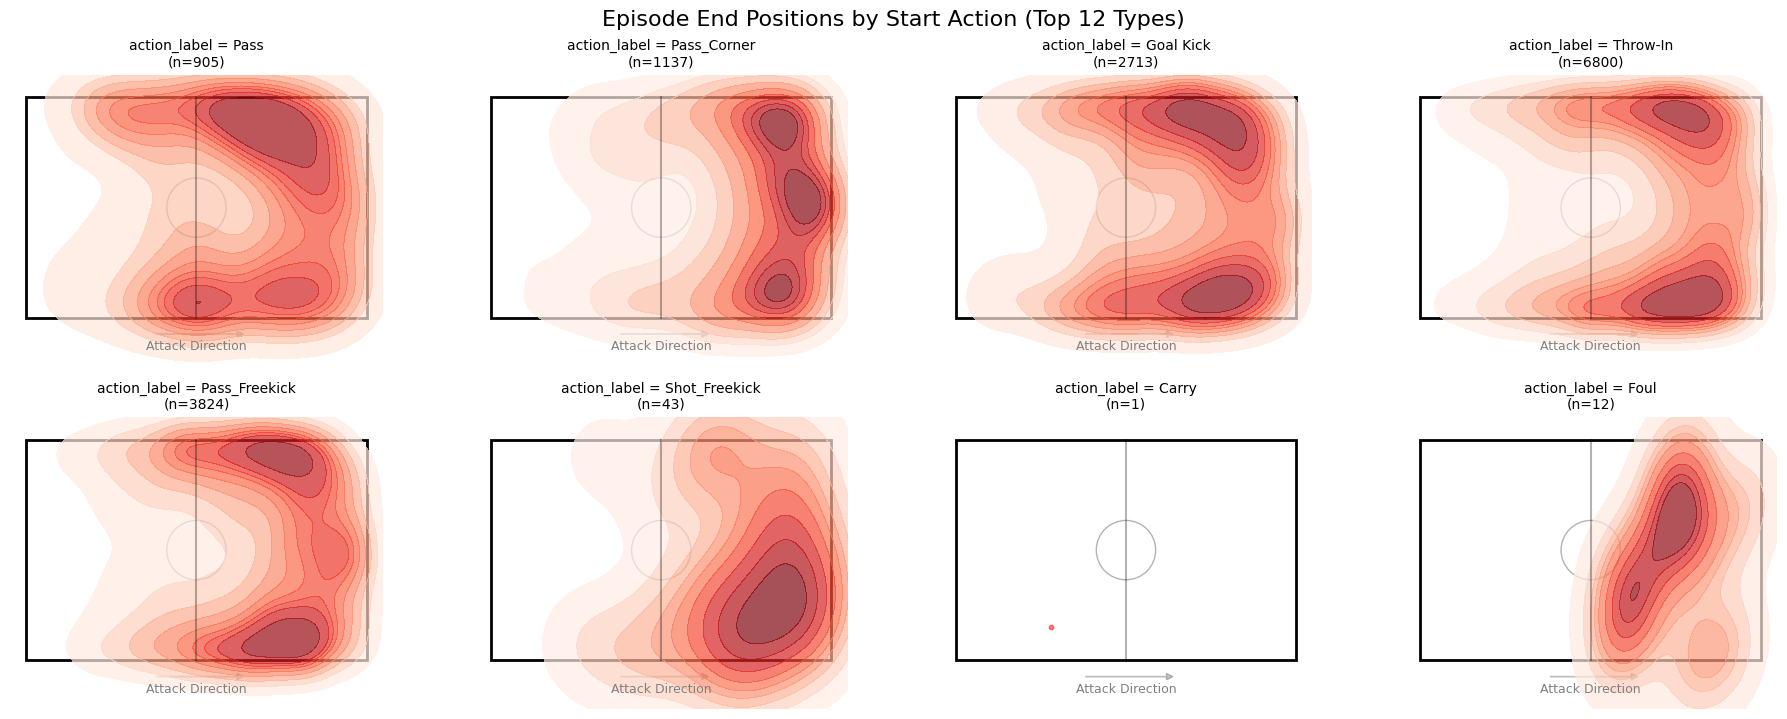

=== 에피소드 시작 행동 빈도 (Top 12) ===
start_action
Throw-In         6800
Pass_Freekick    3824
Goal Kick        2713
Pass_Corner      1137
Pass              905
Shot_Freekick      43
Foul               12
Carry               1
Name: count, dtype: int64


In [16]:
df = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds', 'action_id'])

# 고유 에피소드 ID 생성
df['unique_ep_id'] = df['game_id'].astype(str) + '_' + df['period_id'].astype(str) + '_' + df['episode_id'].astype(str)

# 3. 데이터 집계 (에피소드 단위)
# - start_action: 에피소드의 첫 번째 이벤트 타입
# - end_x, end_y: 에피소드의 마지막 이벤트 종료 좌표
episode_summary = df.groupby('unique_ep_id').agg(
    start_action=('type_name', 'first'),
    end_x=('end_x', 'last'),
    end_y=('end_y', 'last'),
    count=('action_id', 'count')
).reset_index()

# 4. 분석 대상 선정 (빈도수 상위 12개 행동)
top_start_actions = episode_summary['start_action'].value_counts().head(12)
top_actions_list = top_start_actions.index.tolist()

# 상위 행동에 해당하는 데이터만 필터링
filtered_data = episode_summary[episode_summary['start_action'].isin(top_actions_list)].copy()

# 시각화를 위해 라벨에 개수 추가 (예: "Pass (n=1200)")
filtered_data['action_label'] = filtered_data['start_action'].apply(
    lambda x: f"{x}\n(n={top_start_actions[x]})"
)

# 5. 시각화

def draw_pitch(ax):
    # 경기장 그리기
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    
    # 공격 방향
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_kde_on_pitch(x, y, **kwargs):
    ax = plt.gca()
    draw_pitch(ax)
    # 데이터 포인트가 너무 적으면(10개 미만) KDE 에러가 날 수 있어 예외 처리
    if len(x) > 10:
        sns.kdeplot(x=x, y=y, fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=ax)
    else:
        # 데이터가 적으면 산점도로 대체
        ax.scatter(x, y, color='red', alpha=0.5, s=10)

# FacetGrid를 사용하여 다중 플롯 생성 (4열 구조)
g = sns.FacetGrid(filtered_data, col="action_label", col_wrap=4, height=3.5, aspect=1.4)
g.map(plot_kde_on_pitch, "end_x", "end_y")

# 전체 타이틀 설정
g.fig.suptitle("Episode End Positions by Start Action (Top 12 Types)", fontsize=16, y=1.02)

plt.show()

# 간단한 통계 출력
print("=== 에피소드 시작 행동 빈도 (Top 12) ===")
print(top_start_actions)

=== 에피소드 길이 통계 ===
count    15435.000000
mean        23.111176
std         21.990855
min          1.000000
25%          8.000000
50%         16.000000
75%         31.000000
max        270.000000
Name: count, dtype: float64


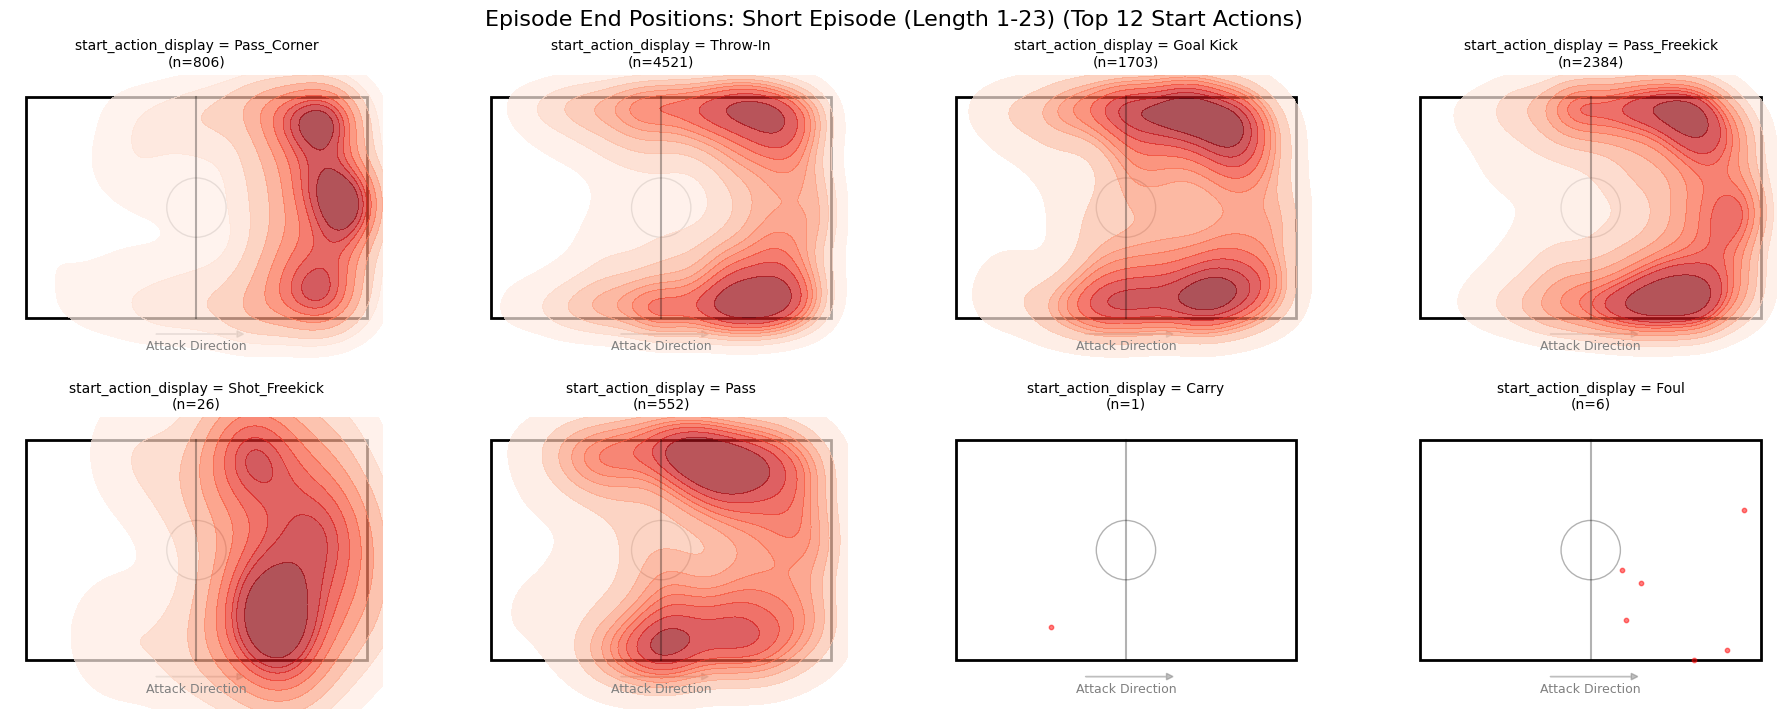


=== Top 12 Start Actions for Short Episode (Length 1-23) ===
start_action
Throw-In         4521
Pass_Freekick    2384
Goal Kick        1703
Pass_Corner       806
Pass              552
Shot_Freekick      26
Foul                6
Carry               1
Name: count, dtype: int64


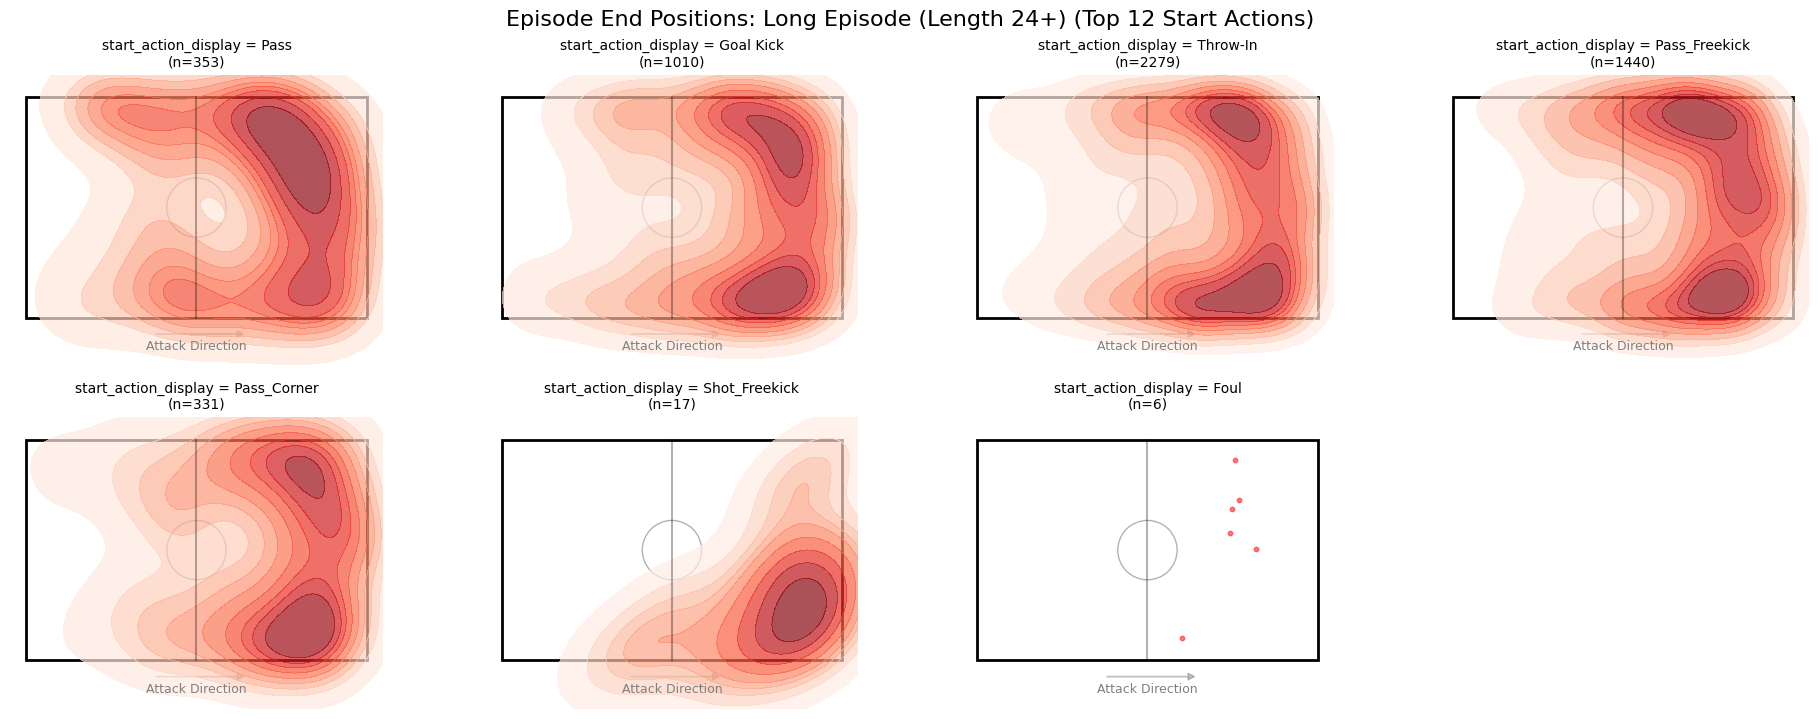


=== Top 12 Start Actions for Long Episode (Length 24+) ===
start_action
Throw-In         2279
Pass_Freekick    1440
Goal Kick        1010
Pass              353
Pass_Corner       331
Shot_Freekick      17
Foul                6
Name: count, dtype: int64


In [23]:
df = df.sort_values(['game_id', 'period_id', 'episode_id', 'time_seconds', 'action_id'])

# 고유 에피소드 ID
df['unique_ep_id'] = df['game_id'].astype(str) + '_' + df['period_id'].astype(str) + '_' + df['episode_id'].astype(str)

# 3. 에피소드 단위 데이터 집계
episode_summary = df.groupby('unique_ep_id').agg(
    start_action=('type_name', 'first'),
    end_x=('end_x', 'last'),
    end_y=('end_y', 'last'),
    count=('action_id', 'count') # 에피소드 길이 (이벤트 개수)
).reset_index()

# 4. 에피소드 길이 통계 확인 (기준 설정을 위해)
print("=== 에피소드 길이 통계 ===")
print(episode_summary['count'].describe())

# 5. 길이 분류 (Short: 1~10, Long: 11+)
# 에피소드는 페이즈보다 기므로 기준을 10으로 설정했습니다. (필요 시 수정 가능)
episode_summary['length_type'] = episode_summary['count'].apply(lambda x: 'Short (1-23)' if x <= 23 else 'Long (24+)')

# ---------------------------------------------------------
# 6. 시각화 함수 정의
# ---------------------------------------------------------
def draw_pitch(ax):
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=9, color='gray')
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_kde_on_pitch(x, y, **kwargs):
    ax = plt.gca()
    draw_pitch(ax)
    if len(x) > 10: 
        sns.kdeplot(x=x, y=y, fill=True, cmap='Reds', thresh=0.05, alpha=0.7, ax=ax)
    else:
        ax.scatter(x, y, color='red', s=10, alpha=0.5)
        if len(x) == 0:
            ax.text(52.5, 34, "No Data", ha='center')

def visualize_episode_group(data, group_name):
    # 빈도수 상위 12개 행동 추출
    action_counts = data['start_action'].value_counts()
    top_actions = action_counts.head(12).index.tolist()
    
    # 상위 12개 행동만 필터링
    filtered_data = data[data['start_action'].isin(top_actions)].copy()
    
    # 라벨에 빈도수 추가
    filtered_data['start_action_display'] = filtered_data['start_action'].apply(
        lambda x: f"{x}\n(n={action_counts[x]})"
    )
    
    # FacetGrid 시각화
    g = sns.FacetGrid(filtered_data, col="start_action_display", col_wrap=4, height=3.5, aspect=1.4)
    g.map(plot_kde_on_pitch, "end_x", "end_y")
    
    g.fig.suptitle(f"Episode End Positions: {group_name} (Top 12 Start Actions)", fontsize=16, y=1.02)
    plt.show()
    
    print(f"\n=== Top 12 Start Actions for {group_name} ===")
    print(action_counts.head(12))

# ---------------------------------------------------------
# 7. 실행 (Short vs Long)
# ---------------------------------------------------------

# (1) Short Episode 시각화
short_data = episode_summary[episode_summary['length_type'] == 'Short (1-23)']
visualize_episode_group(short_data, 'Short Episode (Length 1-23)')

# (2) Long Episode 시각화
long_data = episode_summary[episode_summary['length_type'] == 'Long (24+)']
visualize_episode_group(long_data, 'Long Episode (Length 24+)')